# データの確認(オンメモリ)

## データ読み込みなど

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_profiling as pdp
import gc, os, csv, subprocess, pathlib, sqlite3, logging, time, psycopg2, \
    warnings, datetime
from sqlalchemy import create_engine, MetaData, Table, Column, INTEGER, \
    TEXT, FLOAT, VARCHAR, CHAR, NUMERIC, REAL, func, TIMESTAMP, distinct
from sqlalchemy.orm import scoped_session, sessionmaker
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.ext.automap import automap_base
from contextlib import closing
from plotnine import *
from collections import defaultdict
import seaborn as sns

plt.rcParams["font.family"] = "IPAGothic"
pd.set_option("display.max_columns", 1000)
warnings.filterwarnings('once')
PATH_DB = pathlib.Path("../data/interim/suzuki_phase2_db.sqlite3")
PATH_INTERIM_DATA = pathlib.Path("../data/interim/")
PATH_RAW_DATA = pathlib.Path("../data/raw/dbhaa0001_tbhaa0006/")
PATH_REPORTS = pathlib.Path("../reports/")
PATH_PROCESSED = pathlib.Path("../data/processed/")

In [3]:
from IPython.display import display

def display_all(df):
    with pd.option_context("display.max_rows", 1000):
        with pd.option_context("display.max_columns", 1000):
            display(df)

In [4]:
engine = create_engine(f'sqlite:///{PATH_DB.resolve().as_posix()}')
Base = automap_base()
Base.prepare(engine, reflect=True)
Session = sessionmaker(bind=engine)
meta = MetaData(engine, reflect=True)

/Users/localadmin/anaconda3/envs/suzuki/lib/python3.6/site-packages/ipykernel_launcher.py:5: SADeprecationWarning: reflect=True is deprecate; please use the reflect() method.
  """


In [5]:
Tbhaa = Base.classes["tbhaa_all"]
Dbhaa = Base.classes["dbhaa_all"]

In [29]:
%%time
# random sample (時間がかかる。Teradataだと一瞬だが...)
with closing(Session()) as s:
    df_froc = pd.read_sql(s.query(Tbhaa).order_by(func.random())\
                             .limit(500_000).statement,s.bind)
    df_process = pd.read_sql(s.query(Dbhaa).order_by(func.random())\
                             .limit(500_000).statement,s.bind)

CPU times: user 1min 17s, sys: 2min 6s, total: 3min 23s
Wall time: 4min 51s


In [31]:
# featherフォーマットに保存。圧縮率は低いが、極めて高速に読み込むことができて便利。
# 書き出しには時間がかかる。50秒くらい。
df_froc.to_feather(PATH_INTERIM_DATA/"tbhaa_all_random_500_000.feather")
df_process.to_feather(PATH_INTERIM_DATA/"dbhaa_all_random_500_000.feather")

In [14]:
df_froc = pd.read_feather(PATH_INTERIM_DATA/"tbhaa_all_random_500_000.feather")
df_process = pd.read_feather(PATH_INTERIM_DATA/"dbhaa_all_random_500_000.feather")

/Users/localadmin/anaconda3/envs/suzuki/lib/python3.6/site-packages/pyarrow/pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


**W_FIELD_CLAIM_DIVは1のみを使用**

In [15]:
df_process = df_process.loc[df_process.W_FIELD_CLAIM_DIV=="1",:]

In [16]:
df_process.shape

(348980, 48)

In [17]:
for x in ["df_froc", "df_process"]:
    print(x)
    display(eval(x).head())

df_froc


,V_BASE_CD,V_PROD_DIV,V_VIN,V_ENGINE_NO,V_MOTOR_NO,V_MISSON_NO,V_KEY_NO,V_FCOK,V_FCOK_TIME,V_ABOK,V_ABOK_TIME,V_PROD_MODEL_CD,V_SALES_MODEL_CD,V_SALES_MODEL_NM,V_SPEC,V_COLOR,V_PLANT_CD,V_DIST_CD,V_BRANCH_CD,V_SHIPPING_DATE,V_SHIPPING_FCOK,V_SHIPPING_ABOK,V_INVOICE_NO,V_SALES_NO,V_CASE_NO,V_SRC_DIV,V_CRT_TIME_STAMP
0,100100,B,JB23W-666295,K6A-A472721,None,1J08828,51141,20111027,253624,20111027,245744,YR6F8BCH,JB23W-JXGU-D8,None,000,Z2S,None,405130,405360,None,None,None,None,None,None,1,16-12-15 17:49:35.835799000
1,100100,B,HA36S-225349,R06A-K147146,None,53F09951,50757,20150307,132322,20150307,124406,Y3J51BVP,HA36S-ABXQ-A,None,000,ZJ3,None,407100,407750,None,None,None,None,None,None,1,16-12-15 16:50:35.636516000
2,100100,A,JS1GR7GAX52100978,R736 -140320,None,None,None,20050127,125800,20050127,124700,XA348,GSX750FK5,None,E28,LA1,None,302010,None,20050209,None,None,AS-23748,ADD-1664,321522,1,16-12-15 13:37:27.503402000
3,100100,B,JSAEGA31S00101811,G16B-138450,None,S513125,U0297,19950222,155400,19950222,114900,YB161CD3,SY416G,None,E18,26U,None,215500,None,19950304,None,None,BT-14907,BWD-3811,000114,1,16-12-15 10:50:49.563035000
4,118700,A,MH8BE4DUAAJ152177,E470-ID158338,None,None,None,20100915,101900,20100915,100900,XC601-SD,None,None,P12,None,None,None,None,None,None,None,None,None,None,1,16-12-15 17:25:14.435039000


df_process


,W_KEY,W_BASE_CD,W_PROD_BASE_CD,W_FIELD_CLAIM_DIV,W_PROD_DIV,W_DMEX_DIV,W_PROCESS_MONTH,W_DIST_CD,W_DIST_COUNTRY_CD,W_DIST_ISSUE_NO,W_SHOP_DIV,W_SHOP_CD,W_DIV1,W_DIV2,W_DIV3,W_FIXED_DIV,W_MINUS_DIV,W_SRC_DIV,W_SRC_KEY,W_VIN,W_FCOK,W_PROD_MODEL_CD,W_SALES_DATE,W_FAILURE_DATE,W_MILEAGE_DIV,W_MILEAGE,W_CAUSAL_PART_NO,W_TROUBLE_CC,W_TROUBLE_CP,W_TROUBLE_DF,W_TROUBLE_MP,W_DTC_1,W_DTC_2,W_OPERATION_CD,W_PARTS_AMT,W_LABOR_HOUR,W_LABOR_AMT,W_SUBLET_HOUR,W_SUBLET_AMT,W_SHIPPING_AMT,W_TOTAL_AMT,W_CFC_COMPANY_CD,W_CFC_RATE,W_CFC_AMT,W_FC_TO_FAILURE,W_SALES_TO_FAILURE,W_SB_NO,W_CRT_TIME_STAMP
1,WRCAJP199710B002904,100100,100100,1,B,1,199710,1050B,CA,215651,1,None,A,0,0,1,1,1,1997101050B215651,JS2AA44S1P5100700,19921201,Y3F15,19930226,19970902,K,73200,18213-60B00,None,03,18,None,None,None,DA38R0,2783.0,0.5,2502.0,0.0,0.0,2393.0,7678.0,X101,0,0.0,57,55,None,17-06-16 08:05:11.728268000
3,WRFRJP201211A000130,100100,100100,1,A,1,201211,3135A,FR,2A169420,1,None,None,0,0,1,1,1,2012113135A2A169420,JS1CX111100108906,20100901,XC153,20120308,20121019,K,3042,57460-17C11,None,35,36,None,None,None,SF10R0,439.0,0.2,813.0,0.0,0.0,131.0,1383.0,3647,50,674.0,25,8,None,17-06-19 12:29:35.822490000
4,WRFIJP201308B000001,100100,100100,1,B,1,201308,5471B,FI,30010099,1,None,None,0,0,1,1,1,2013085471B30010099,JSAFJB43V00509610,20110201,YR7K8,20110519,20130726,K,49267,09265-15006,None,84,35,None,None,None,HC11R0,2395.0,1.3,10193.0,0.0,0.0,956.0,13544.0,3059,0,0.0,29,27,None,17-06-19 13:24:52.988303000
5,WRJPJP201702B007351,100100,100100,1,B,0,201702,30708,JP,17B0009061,1,031,1,0,None,1,1,1,201702008068029,MR31S-207696,20140201,YMA51B9E,20140224,20170204,K,23299,33910-50M50,42,03,84,4,None,None,None,0.0,1.0,6200.0,0.0,0.0,0.0,6200.0,3223,38,2356.0,36,36,None,17-08-02 18:36:00.754091000
6,WRJPJP199803B025013,100100,100100,1,B,0,199803,50002,JP,None,1,9,1,0,None,1,1,1,199803005164166,TA01W-944982,19970401,None,19971002,19980220,K,27400,33920-70EG0,31,01,99,3,None,None,None,66300.0,0.3,1500.0,0.0,0.0,0.0,67800.0,3223,0,0.0,10,5,None,17-06-16 08:13:50.627213000


In [18]:
df_process.head()

,W_KEY,W_BASE_CD,W_PROD_BASE_CD,W_FIELD_CLAIM_DIV,W_PROD_DIV,W_DMEX_DIV,W_PROCESS_MONTH,W_DIST_CD,W_DIST_COUNTRY_CD,W_DIST_ISSUE_NO,W_SHOP_DIV,W_SHOP_CD,W_DIV1,W_DIV2,W_DIV3,W_FIXED_DIV,W_MINUS_DIV,W_SRC_DIV,W_SRC_KEY,W_VIN,W_FCOK,W_PROD_MODEL_CD,W_SALES_DATE,W_FAILURE_DATE,W_MILEAGE_DIV,W_MILEAGE,W_CAUSAL_PART_NO,W_TROUBLE_CC,W_TROUBLE_CP,W_TROUBLE_DF,W_TROUBLE_MP,W_DTC_1,W_DTC_2,W_OPERATION_CD,W_PARTS_AMT,W_LABOR_HOUR,W_LABOR_AMT,W_SUBLET_HOUR,W_SUBLET_AMT,W_SHIPPING_AMT,W_TOTAL_AMT,W_CFC_COMPANY_CD,W_CFC_RATE,W_CFC_AMT,W_FC_TO_FAILURE,W_SALES_TO_FAILURE,W_SB_NO,W_CRT_TIME_STAMP
1,WRCAJP199710B002904,100100,100100,1,B,1,199710,1050B,CA,215651,1,None,A,0,0,1,1,1,1997101050B215651,JS2AA44S1P5100700,19921201,Y3F15,19930226,19970902,K,73200,18213-60B00,None,03,18,None,None,None,DA38R0,2783.0,0.5,2502.0,0.0,0.0,2393.0,7678.0,X101,0,0.0,57,55,None,17-06-16 08:05:11.728268000
3,WRFRJP201211A000130,100100,100100,1,A,1,201211,3135A,FR,2A169420,1,None,None,0,0,1,1,1,2012113135A2A169420,JS1CX111100108906,20100901,XC153,20120308,20121019,K,3042,57460-17C11,None,35,36,None,None,None,SF10R0,439.0,0.2,813.0,0.0,0.0,131.0,1383.0,3647,50,674.0,25,8,None,17-06-19 12:29:35.822490000
4,WRFIJP201308B000001,100100,100100,1,B,1,201308,5471B,FI,30010099,1,None,None,0,0,1,1,1,2013085471B30010099,JSAFJB43V00509610,20110201,YR7K8,20110519,20130726,K,49267,09265-15006,None,84,35,None,None,None,HC11R0,2395.0,1.3,10193.0,0.0,0.0,956.0,13544.0,3059,0,0.0,29,27,None,17-06-19 13:24:52.988303000
5,WRJPJP201702B007351,100100,100100,1,B,0,201702,30708,JP,17B0009061,1,031,1,0,None,1,1,1,201702008068029,MR31S-207696,20140201,YMA51B9E,20140224,20170204,K,23299,33910-50M50,42,03,84,4,None,None,None,0.0,1.0,6200.0,0.0,0.0,0.0,6200.0,3223,38,2356.0,36,36,None,17-08-02 18:36:00.754091000
6,WRJPJP199803B025013,100100,100100,1,B,0,199803,50002,JP,None,1,9,1,0,None,1,1,1,199803005164166,TA01W-944982,19970401,None,19971002,19980220,K,27400,33920-70EG0,31,01,99,3,None,None,None,66300.0,0.3,1500.0,0.0,0.0,0.0,67800.0,3223,0,0.0,10,5,None,17-06-16 08:13:50.627213000


## データ確認(前回まで)

In [19]:
for x in ["df_froc", "df_process"]: print(x, ":", eval(x).shape)

df_froc : (500000, 27)
df_process : (348980, 48)


In [20]:
# 基礎統計量一覧
for x in ["df_froc", "df_process"]: 
    print(x)
    tmp = eval(x).describe(include="all")
    display(tmp)
    tmp.to_csv(PATH_PROCESSED/f"20190621_describe_{x}.csv")

df_froc


,V_BASE_CD,V_PROD_DIV,V_VIN,V_ENGINE_NO,V_MOTOR_NO,V_MISSON_NO,V_KEY_NO,V_FCOK,V_FCOK_TIME,V_ABOK,V_ABOK_TIME,V_PROD_MODEL_CD,V_SALES_MODEL_CD,V_SALES_MODEL_NM,V_SPEC,V_COLOR,V_PLANT_CD,V_DIST_CD,V_BRANCH_CD,V_SHIPPING_DATE,V_SHIPPING_FCOK,V_SHIPPING_ABOK,V_INVOICE_NO,V_SALES_NO,V_CASE_NO,V_SRC_DIV,V_CRT_TIME_STAMP
count,500000,500000,500000,489315,0.0,156085,239772,500000,466039,459869,425106,491373,339929,0.0,480652,350475,0.0,351226,155734,239430,1666,1661,144774,145127,145127,500000,500000
unique,25,5,500000,486559,0.0,148611,11106,8038,62880,7713,64214,15580,13786,0.0,204,999,0.0,2829,1154,8458,1054,1035,52614,33491,44571,1,499978
top,100100,B,DA62V-383272,157FMI-3B2X11,NaN,,,20180112,000000,20,141600,XF331EH,SN413V,NaN,000,26U,NaN,304010,361000,20000000,20150328,20160307,,AAD-2383,000001,1,16-12-15 15:02:06.073278000
freq,313579,314460,1,18,NaN,5221,2862,216,22838,4990,420,5330,5025,NaN,160226,42811,NaN,18428,12372,381,10,7,213,276,1282,500000,2


df_process


,W_KEY,W_BASE_CD,W_PROD_BASE_CD,W_FIELD_CLAIM_DIV,W_PROD_DIV,W_DMEX_DIV,W_PROCESS_MONTH,W_DIST_CD,W_DIST_COUNTRY_CD,W_DIST_ISSUE_NO,W_SHOP_DIV,W_SHOP_CD,W_DIV1,W_DIV2,W_DIV3,W_FIXED_DIV,W_MINUS_DIV,W_SRC_DIV,W_SRC_KEY,W_VIN,W_FCOK,W_PROD_MODEL_CD,W_SALES_DATE,W_FAILURE_DATE,W_MILEAGE_DIV,W_MILEAGE,W_CAUSAL_PART_NO,W_TROUBLE_CC,W_TROUBLE_CP,W_TROUBLE_DF,W_TROUBLE_MP,W_DTC_1,W_DTC_2,W_OPERATION_CD,W_PARTS_AMT,W_LABOR_HOUR,W_LABOR_AMT,W_SUBLET_HOUR,W_SUBLET_AMT,W_SHIPPING_AMT,W_TOTAL_AMT,W_CFC_COMPANY_CD,W_CFC_RATE,W_CFC_AMT,W_FC_TO_FAILURE,W_SALES_TO_FAILURE,W_SB_NO,W_CRT_TIME_STAMP
count,348980,348980,348979,348980,348980,348980,348980,344901,348980,259020,311374,185323,202182,348980,160752,348980,348980.0,348980,348980,348980,348980,320157,348980,348980,348980,348980.000000,348980,191945,348974,348974,191945,0.0,0.0,157919,348980.000000,348980.000000,3.489800e+05,348980.000000,348980.000000,348980.000000,3.489800e+05,311835,348980.000000,3.489800e+05,348980.000000,348980.000000,1,348980
unique,348980,9,28,1,7,2,267,920,102,246932,5,539,13,9,4,1,NaN,2,348218,341632,5237,10934,9647,8210,2,NaN,62683,57,294,71,11,0.0,0.0,2602,NaN,NaN,NaN,NaN,NaN,NaN,NaN,619,NaN,NaN,NaN,NaN,1,348980
top,WRJPJP200510B034653,100100,100100,1,B,0,200209,1013B,JP,0000000000,1,01,1,0,0,1,NaN,1,201412 *01412-000,JS3TD62V6X4102081,19990301,YH4R2,00000000,00000000,K,NaN,27610-76G24,99,84,99,9,NaN,NaN,EA01R0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3149,NaN,NaN,NaN,NaN,SBJP201208B00064,17-06-19 11:58:55.172293000
freq,1,311374,293753,348980,304065,197389,2108,17241,188228,472,266369,8397,121315,344229,155341,348980,NaN,311374,12,5,2322,2376,1021,142,344716,NaN,3104,93312,66920,63018,115125,NaN,NaN,3268,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15489,NaN,NaN,NaN,NaN,1,1
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24724.625964,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13931.412382,1.303464,8.784315e+03,0.036706,1052.548971,1505.228082,2.300997e+04,NaN,17.595753,3.054722e+04,33.213774,25.918010,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22181.194884,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27782.759621,2.031427,8.487383e+04,2.529288,8509.518510,7579.198815,3.765595e+04,NaN,24.736764,1.155767e+06,64.517474,21.381303,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000e+00,0.000000,0.000000,-1.000000,0.000000e+00,NaN,0.000000,0.000000e+00,-12.000000,0.000000,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6720.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1006.000000,0.300000,1.500000e+03,0.000000,0.000000,0.000000,4.854000e+03,NaN,0.000000,0.000000e+00,14.000000,10.000000,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19230.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4550.000000,0.700000,3.126000e+03,0.000000,0.000000,0.000000,1.163000e+04,NaN,0.000000,0.000000e+00,26.000000,23.000000,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37200.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14365.000000,1.400000,6.717250e+03,0.000000,0.000000,489.000000,2.619225e+04,NaN,35.000000,2.200000e+03,37.000000,36.000000,NaN,NaN


%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
df_froc


,%null,n_null
V_SALES_MODEL_NM,1.000000,500000
V_MOTOR_NO,1.000000,500000
V_PLANT_CD,1.000000,500000
V_SHIPPING_ABOK,0.996678,498339
V_SHIPPING_FCOK,0.996668,498334
V_INVOICE_NO,0.710452,355226
V_SALES_NO,0.709746,354873
V_CASE_NO,0.709746,354873
V_BRANCH_CD,0.688532,344266
V_MISSON_NO,0.687830,343915


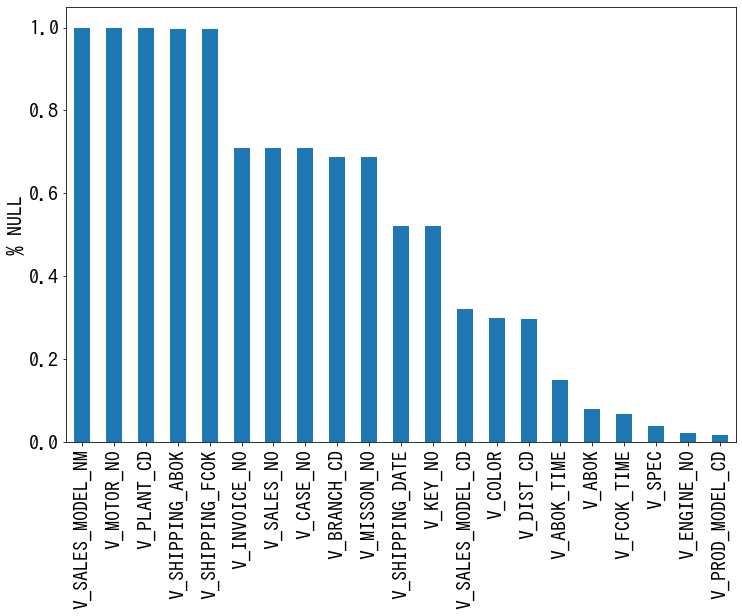

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
df_process


,%null,n_null
W_DTC_1,1.000000,348980
W_DTC_2,1.000000,348980
W_SB_NO,0.999997,348979
W_OPERATION_CD,0.547484,191061
W_DIV3,0.539366,188228
W_SHOP_CD,0.468958,163657
W_TROUBLE_CC,0.449983,157035
W_TROUBLE_MP,0.449983,157035
W_DIV1,0.420649,146798
W_DIST_ISSUE_NO,0.257780,89960


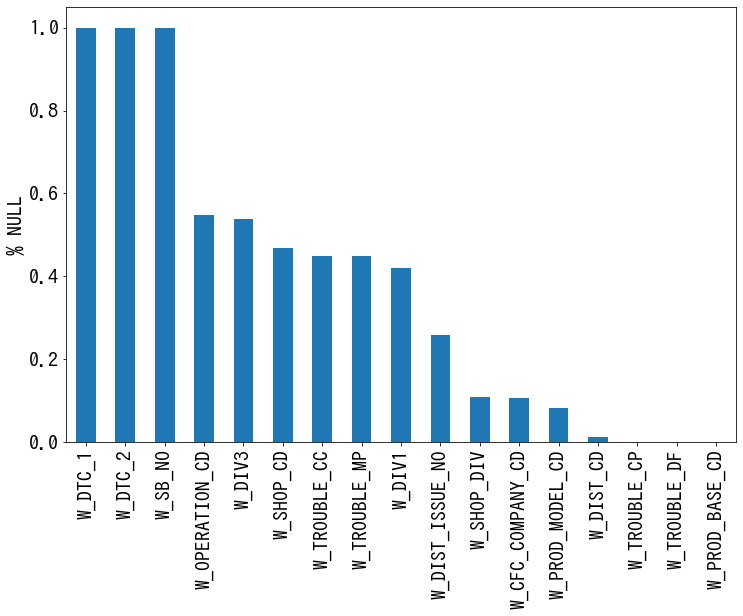

In [21]:
for x in ["df_froc", "df_process"]: 
    print("%" * 100)
    print(x)
    tmp = (eval(x).isna().sum() / eval(x).shape[0]).to_frame(name="%null")
    tmp["n_null"] = eval(x).isna().sum()
    tmp = tmp.sort_values(by="%null", ascending=False)
    display(tmp)
    tmp.to_csv(PATH_PROCESSED/f"20190621_null_ratio_{x}.csv")
    tmp.loc[tmp["%null"] > 0,"%null"].plot(kind="bar", figsize=(12,8),
                                      fontsize=20)
    plt.ylabel("% NULL", fontsize=20)
    plt.savefig(PATH_REPORTS/f"20190621_null_ratio_{x}.png")
    plt.show()

In [22]:
# 比率・間隔・順序尺度変数のヒストグラム
def hist_df(df, bin=30, subplot_col=5, figsize=(20,10),
           savepath=None):
    col_num = [col for col in df.columns 
               if df[col].dtype.name != "object"]
    n_col = len(col_num)
    plt.figure(figsize=figsize)

    for i,col in enumerate(col_num):
        plt.subplot(n_col // subplot_col + 1, subplot_col, i+1)
        df[col].hist(bins=bin)
        plt.title(col)
    plt.tight_layout()
    if savepath: plt.savefig(savepath)
    plt.show()

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
df_froc


<Figure size 1440x720 with 0 Axes>

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
df_process


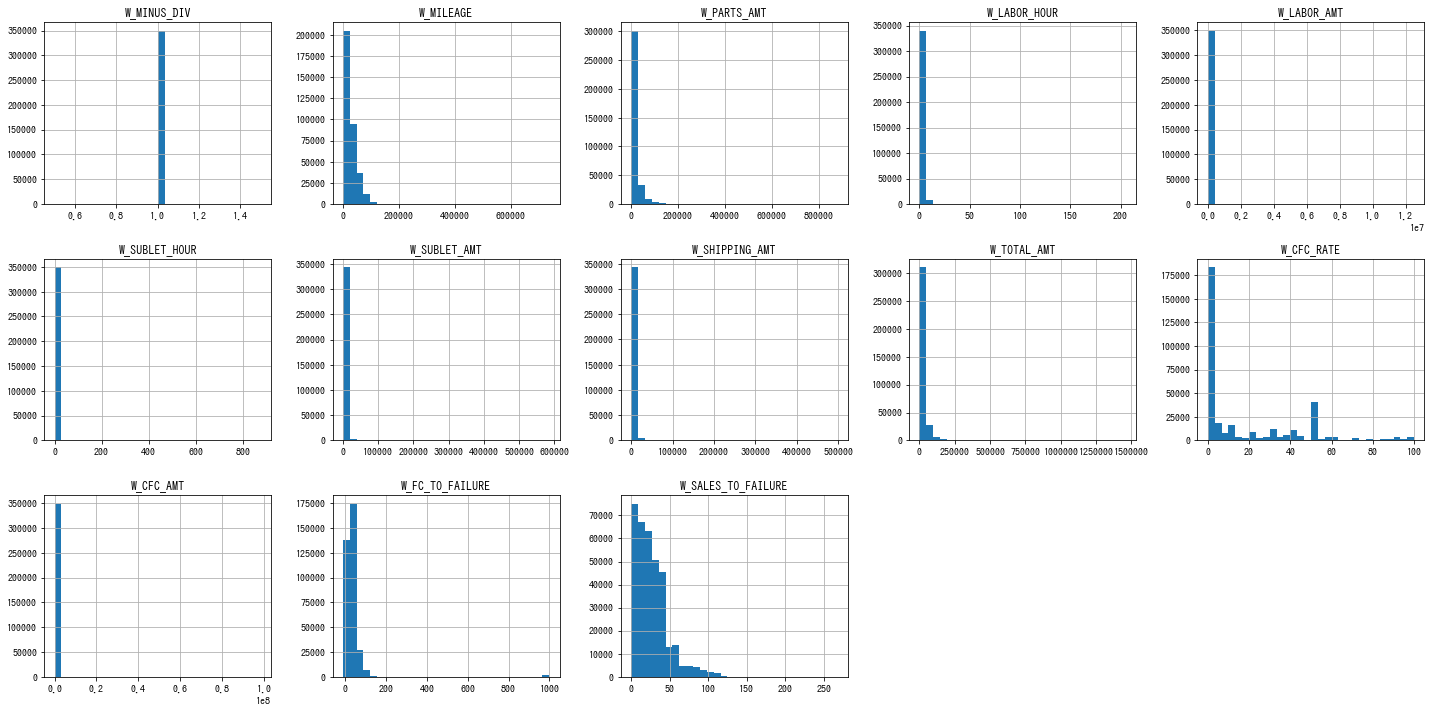

In [23]:
bins=30
for x in ["df_froc", "df_process"]:
    print("%" * 100)
    print(x)
    hist_df(eval(x), bin=bins,
            savepath=PATH_REPORTS/f"20190621_{x}_hist_bins{bins}.png")

In [24]:
# 比率・間隔・順序尺度変数のヒストグラム
def hist_df(df, bin=30, subplot_col=5, figsize=(20,10),
           savepath=None):
    col_num = [col for col in df.columns 
               if df[col].dtype.name != "object"]
    n_col = len(col_num)
    plt.figure(figsize=figsize)

    for i,col in enumerate(col_num):
        plt.subplot(n_col // subplot_col + 1, subplot_col, i+1)
        df[col].hist(bins=bin)
        plt.title(col)
    plt.tight_layout()
    if savepath: plt.savefig(savepath)
    plt.show()

In [25]:
# 名義尺度の棒グラフ
def cat_df(df, n_topcat=10, subplot_col=5, figsize=(20,30),
           g_type="bar", savepath=None):
    
    col_cat = [col for col in df.columns 
               if df[col].dtype.name == "object"]
    n_col = len(col_cat)
    plt.figure(figsize=figsize)
    
    for i,col in enumerate(col_cat):
        plt.subplot(n_col // subplot_col + 1, subplot_col, i+1)
        vc = df[col].value_counts()
        vc_top = vc[:n_topcat]
        vc_other = vc[n_topcat:].sum()
        vc_top["other"] = vc_other
        vc_top.plot(kind=g_type)
        plt.title(col)
    plt.tight_layout()
    if savepath: plt.savefig(savepath)
    plt.show()

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
df_froc


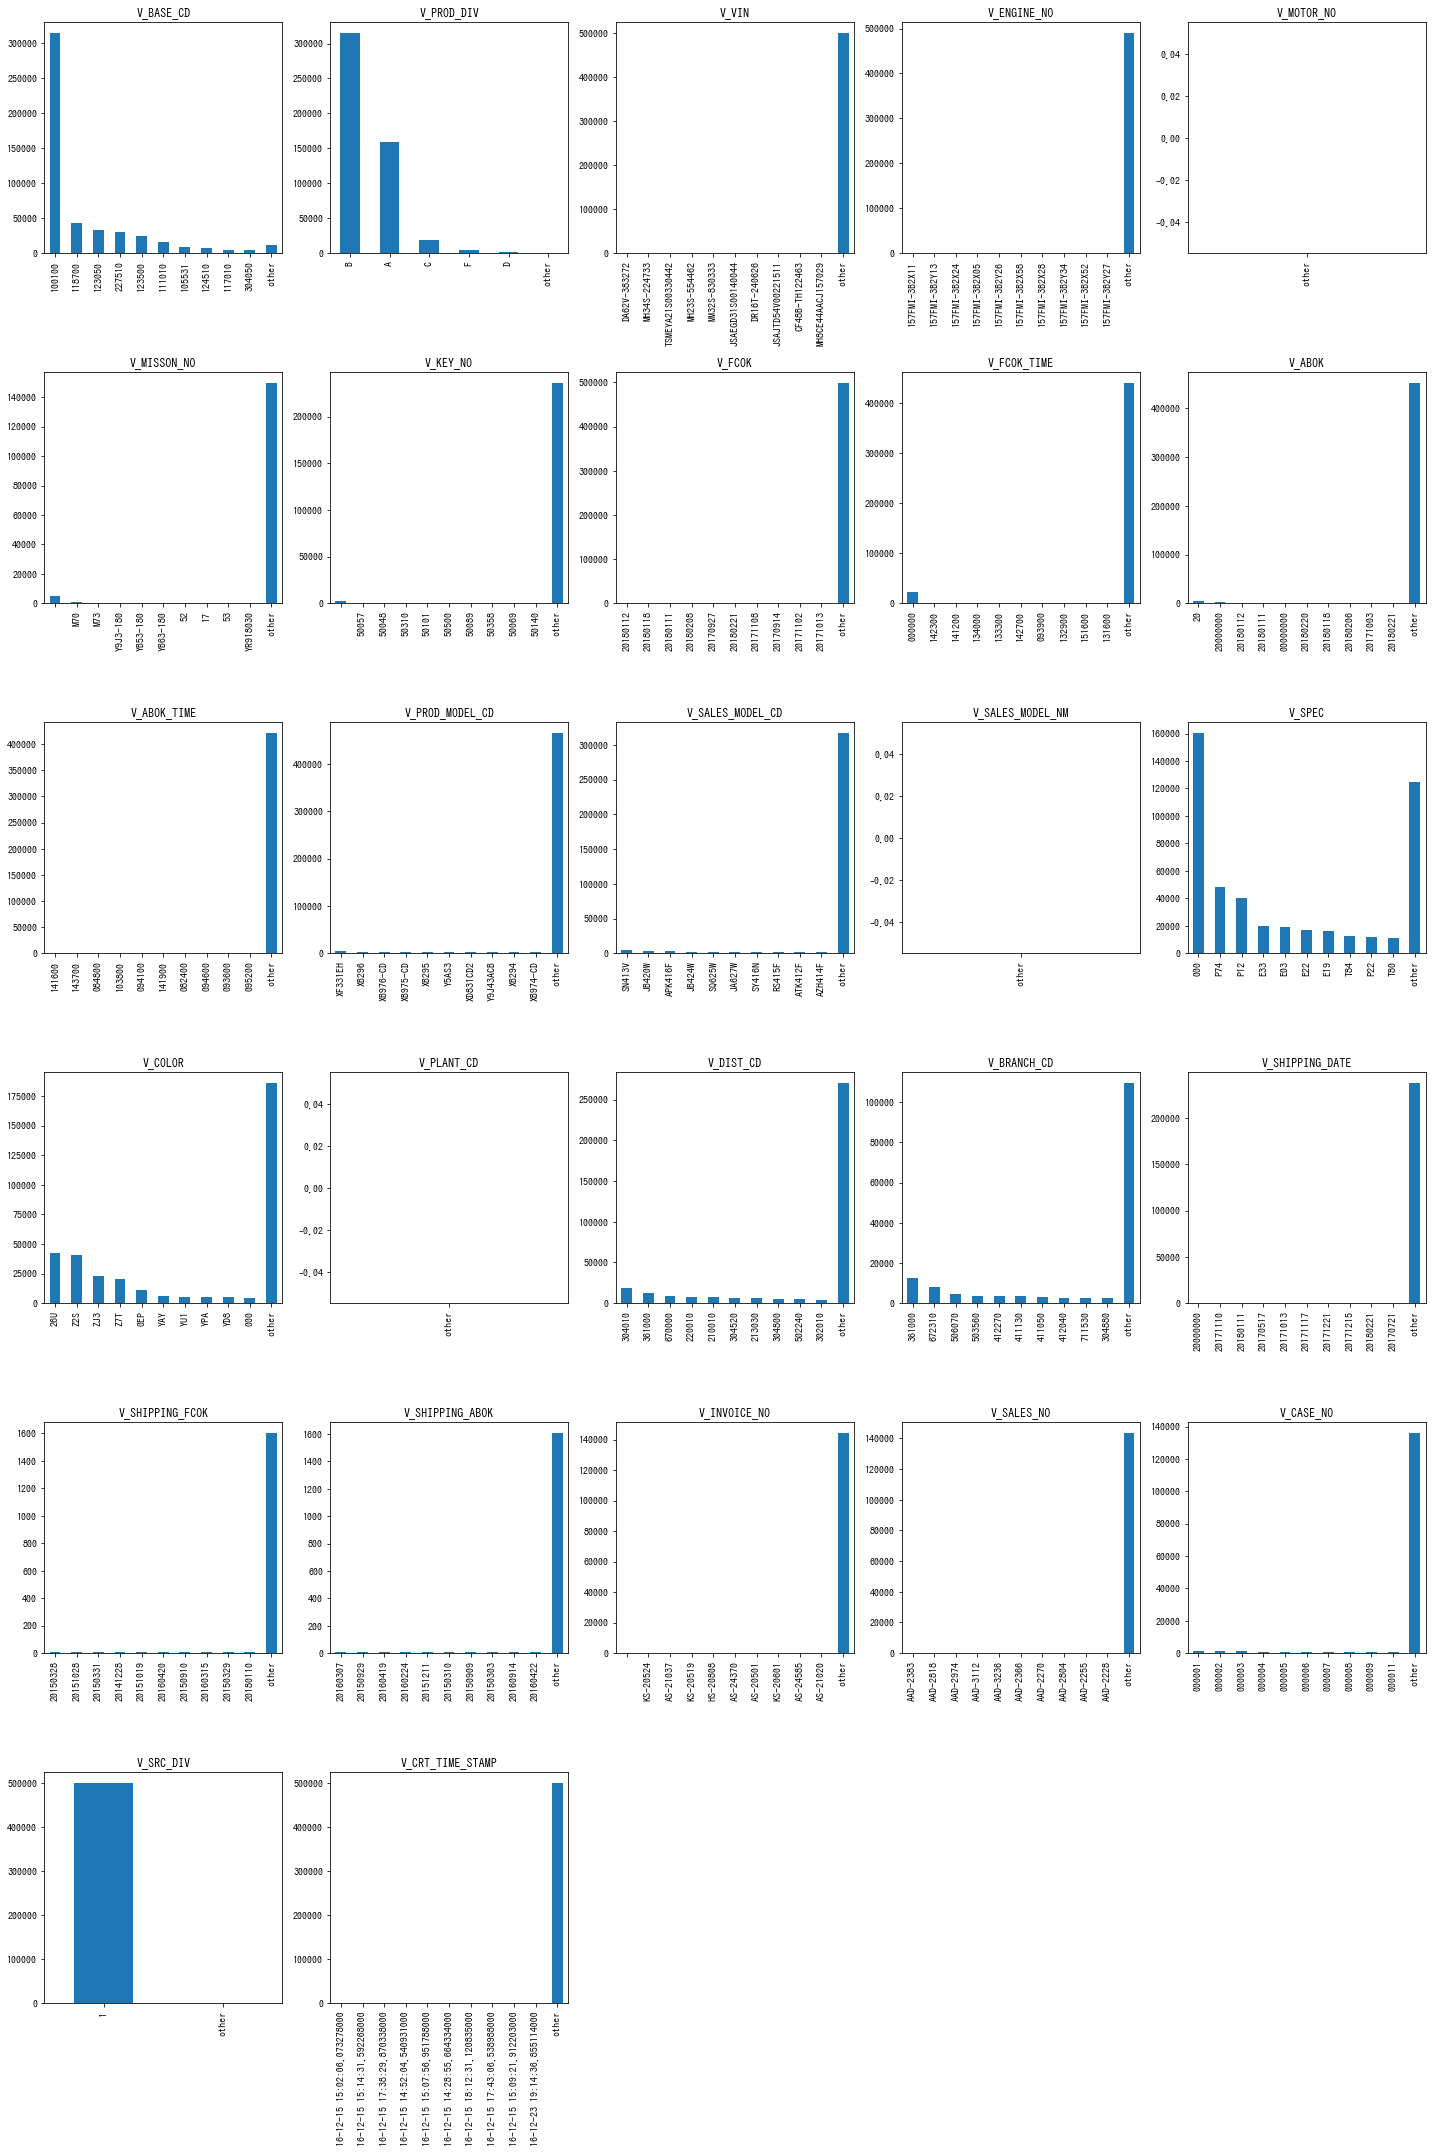

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
df_process


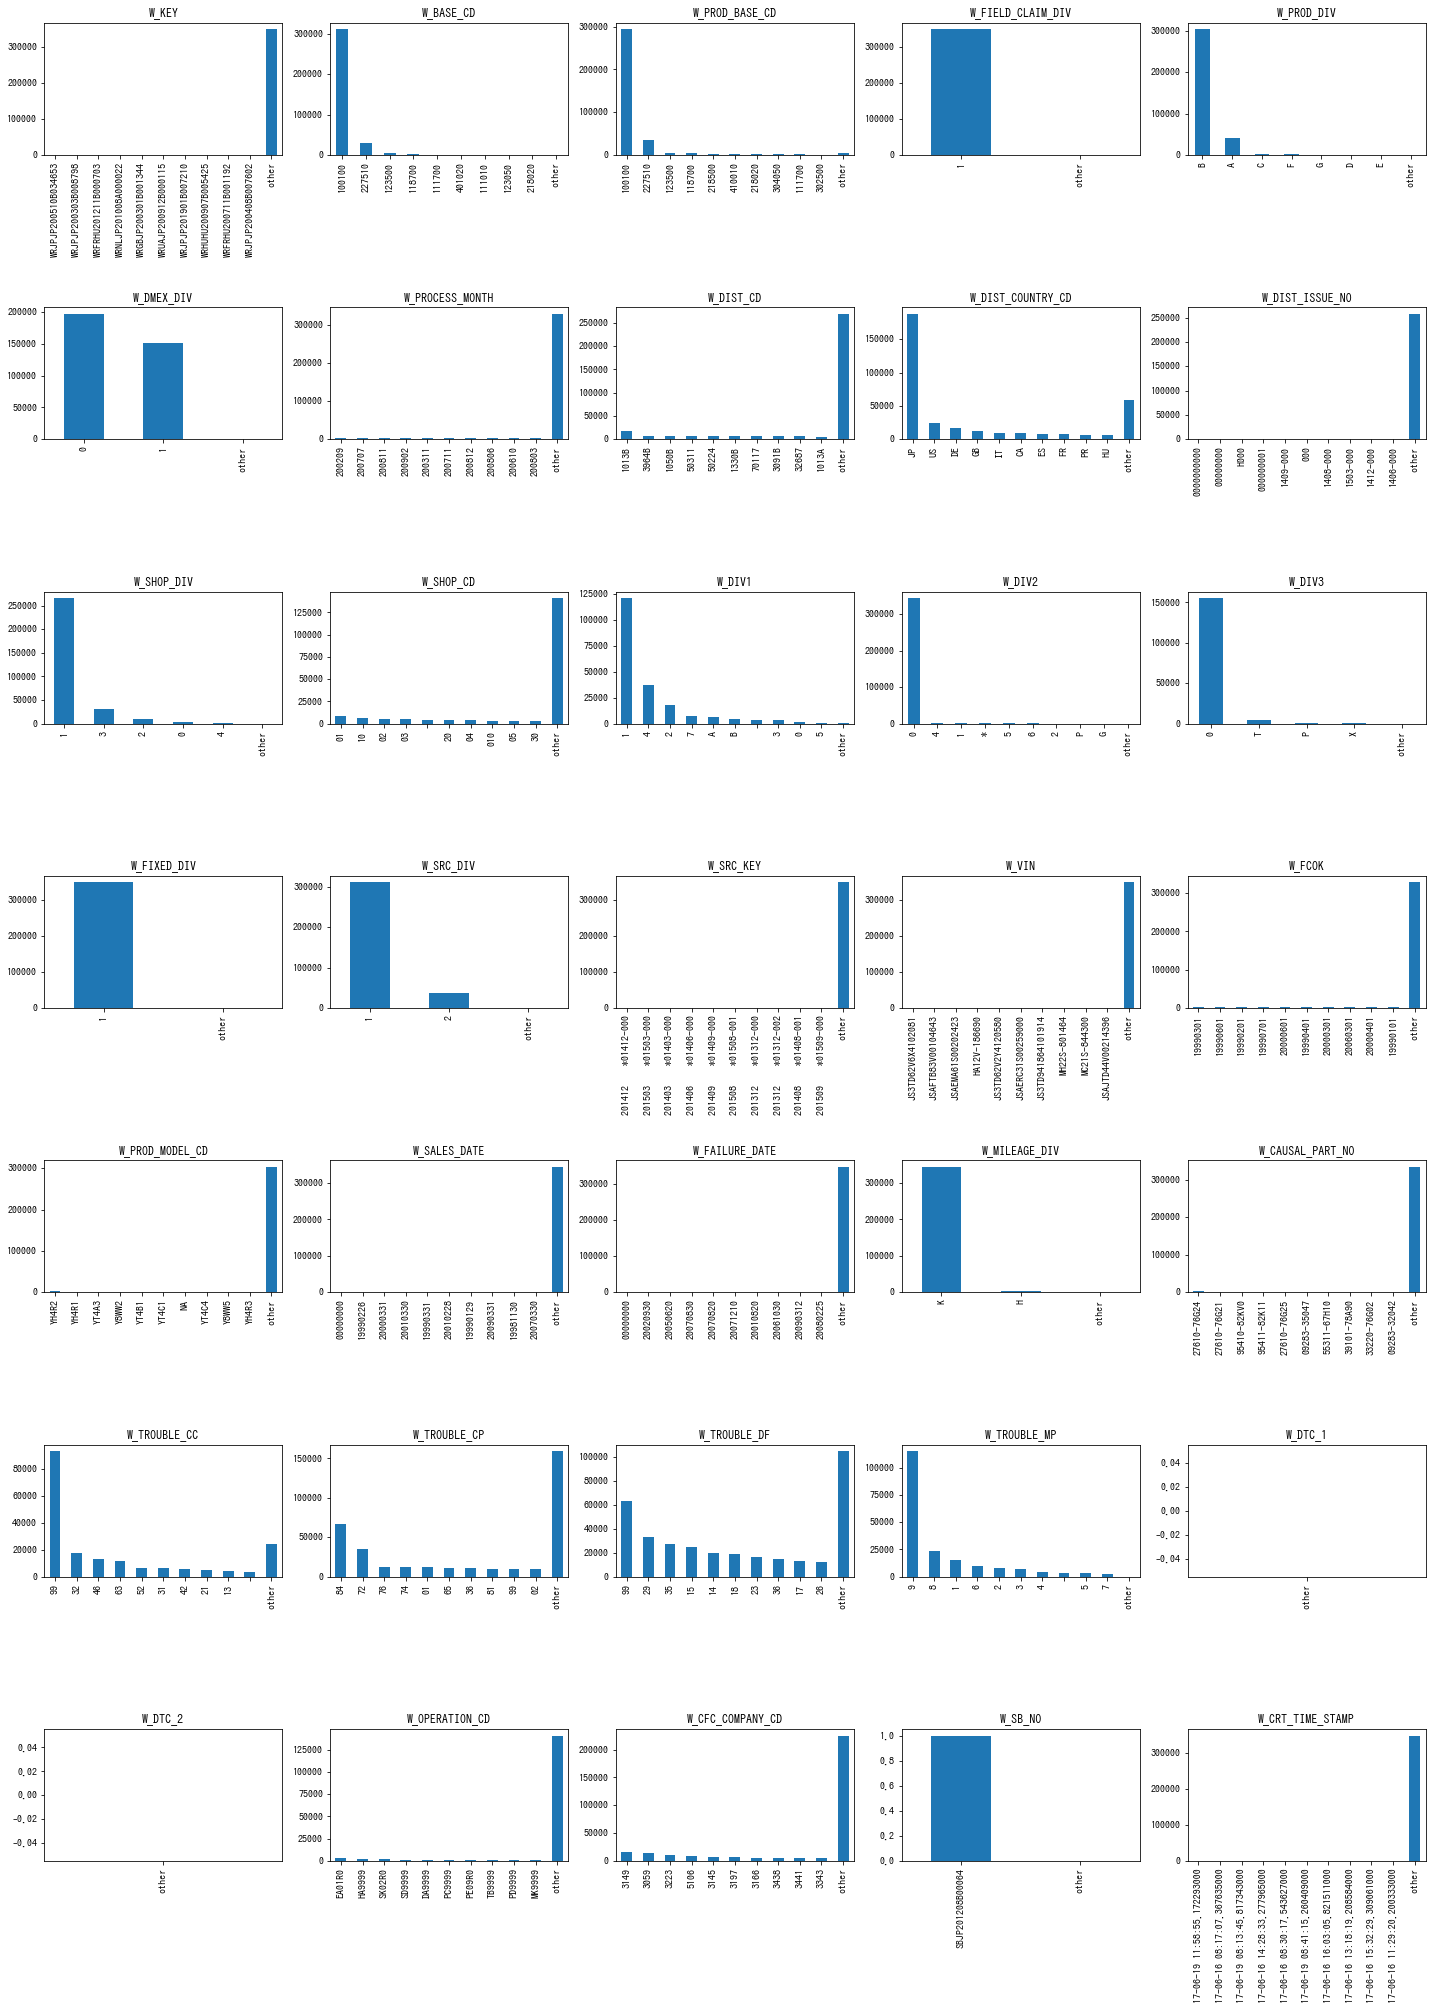

In [26]:
bins=30
for x in ["df_froc", "df_process"]:
    print("%" * 100)
    print(x)
    cat_df(eval(x), n_topcat=10,
            savepath=PATH_REPORTS/f"20190621_{x}_cat_bars_top10.png")

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
df_froc


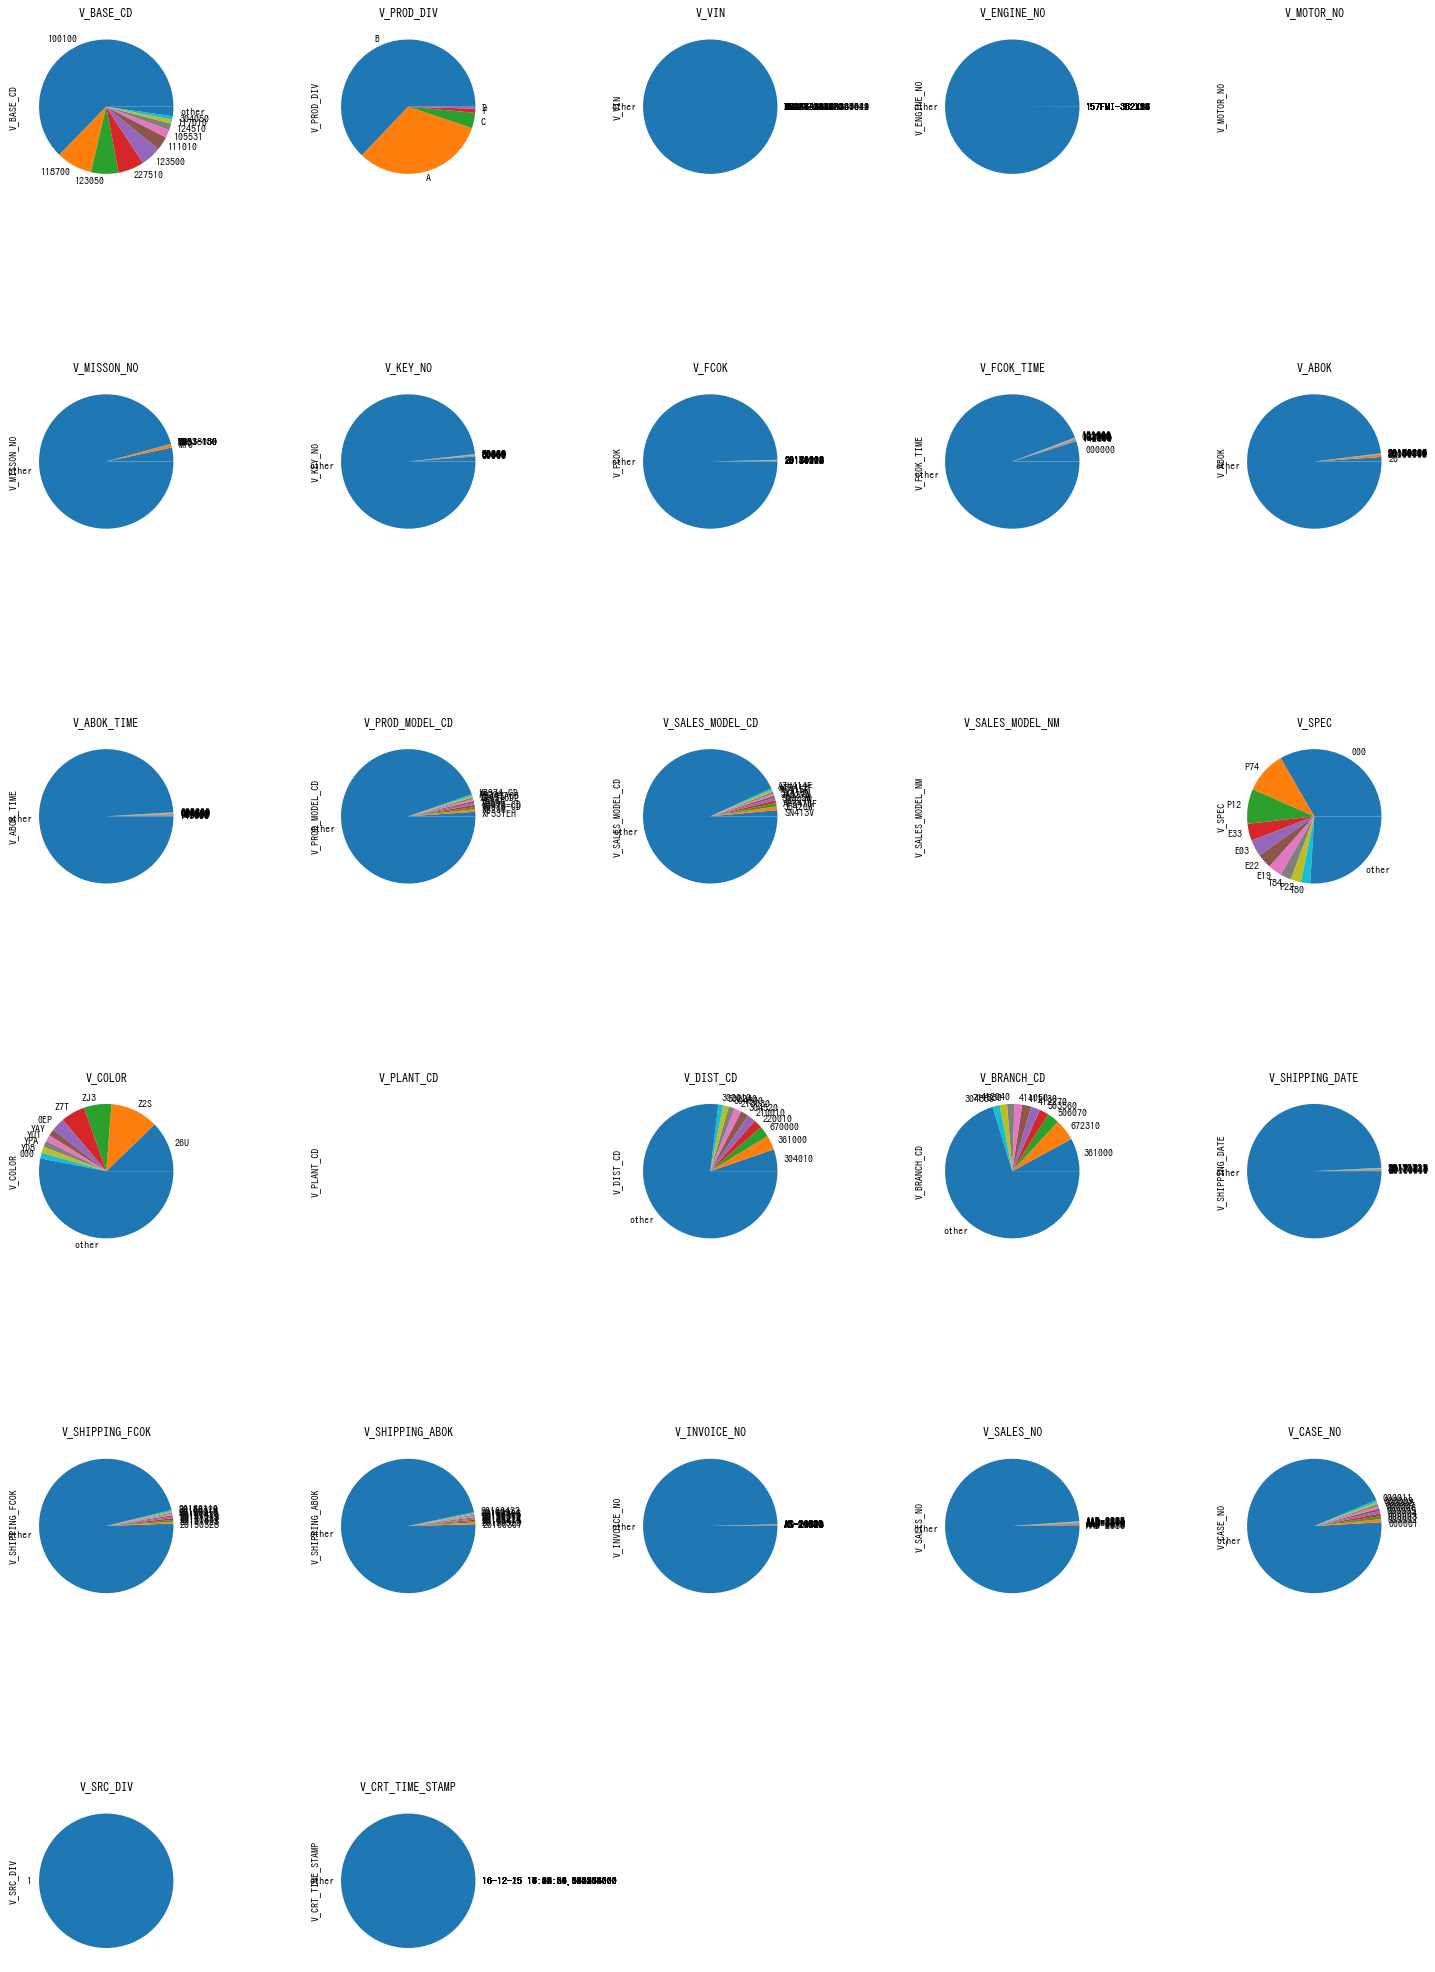

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
df_process


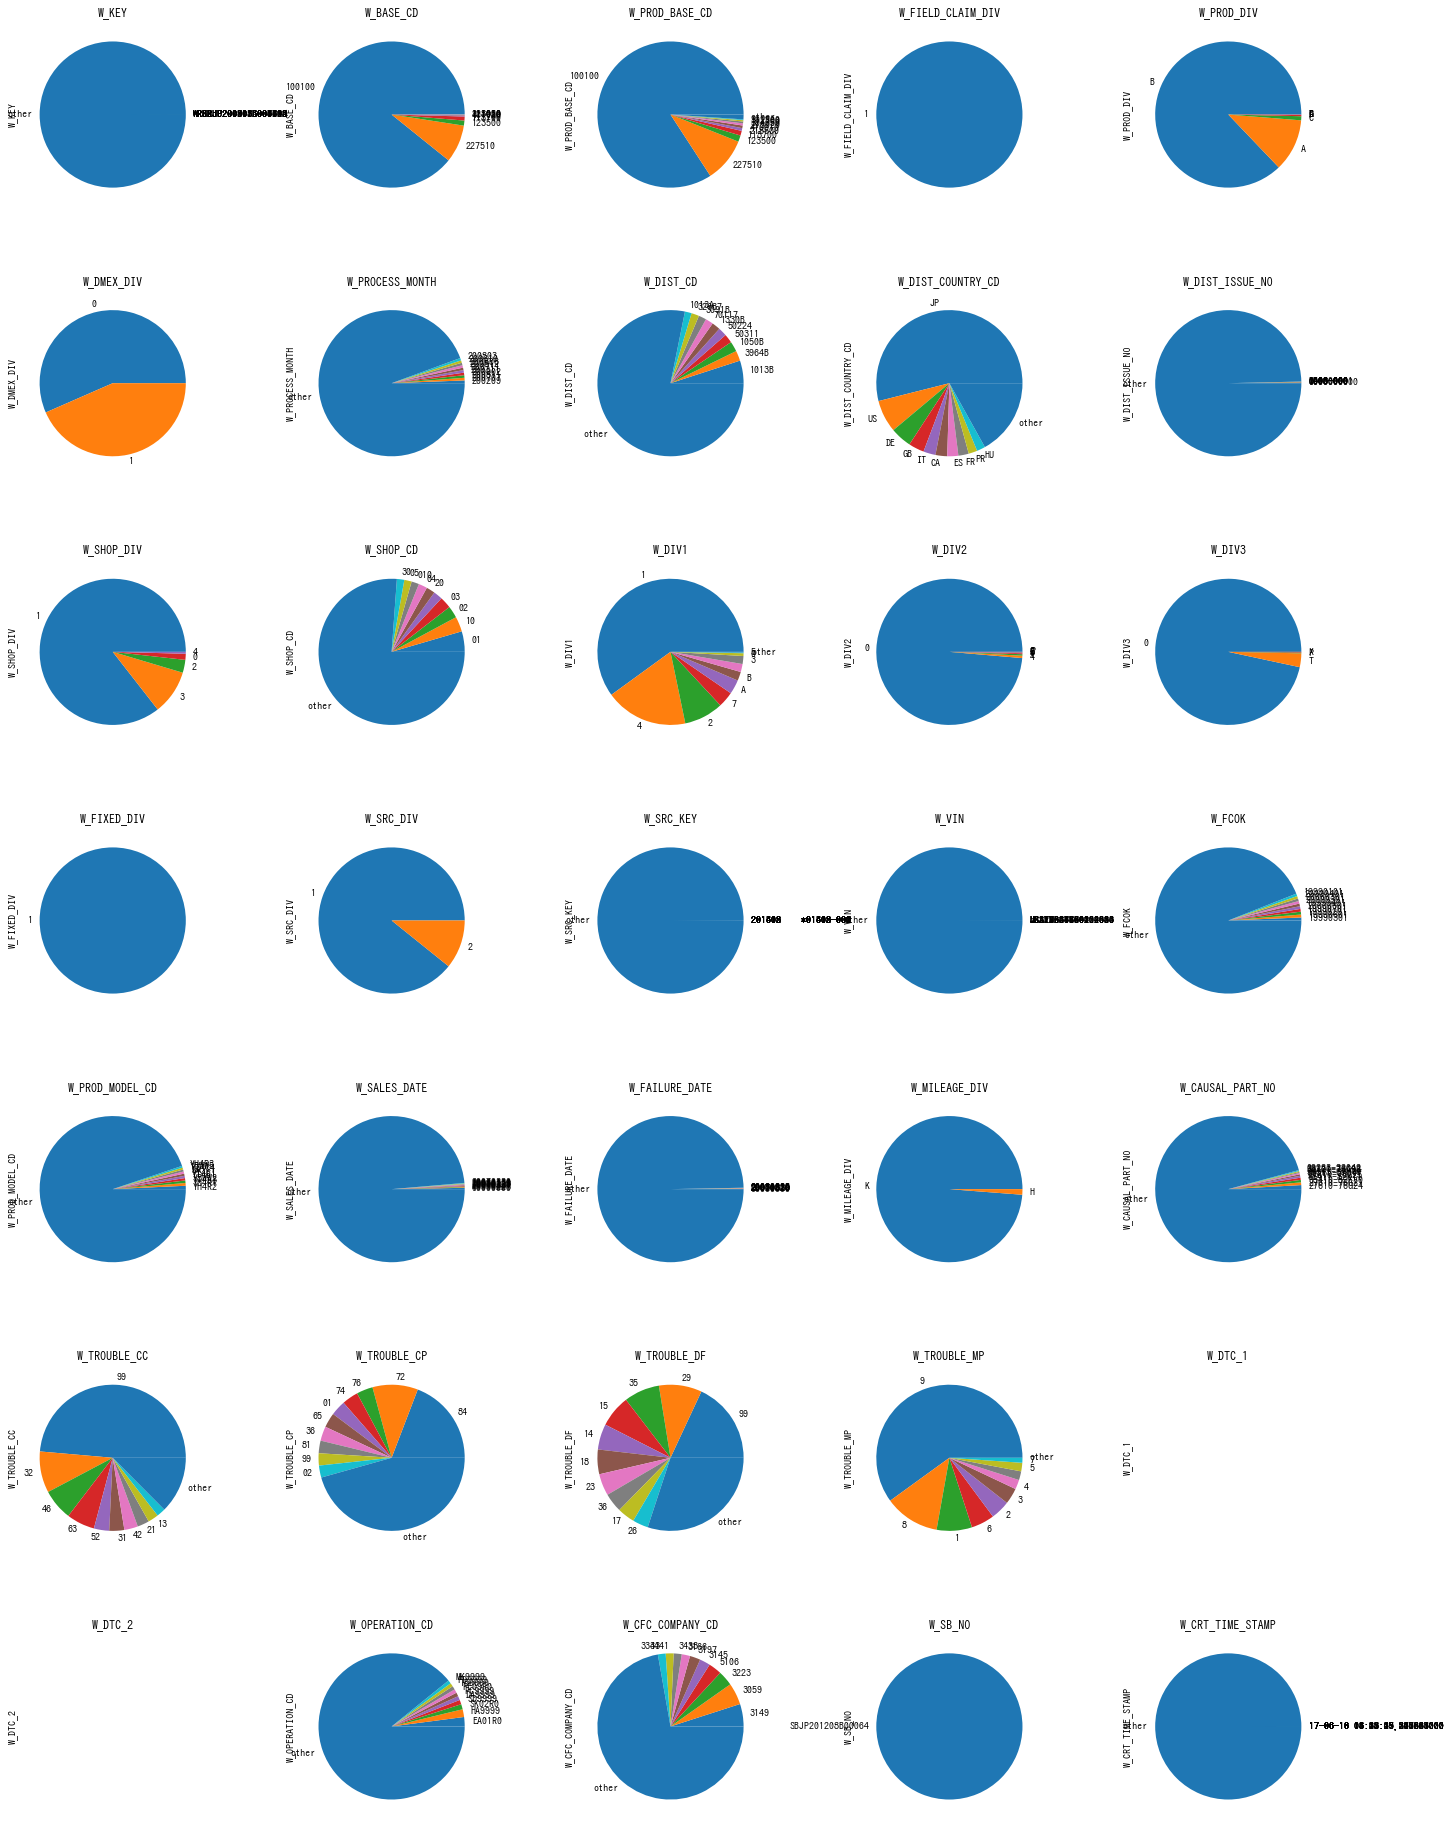

In [27]:
bins=30
for x in ["df_froc", "df_process"]:
    print("%" * 100)
    print(x)
    cat_df(eval(x), n_topcat=10, g_type="pie",
            savepath=PATH_REPORTS/f"20190621_{x}_cat_pie_top10.png")

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
df_process


/Users/localadmin/anaconda3/envs/suzuki/lib/python3.6/site-packages/seaborn/matrix.py:268: PendingDeprecationWarning: 
The label function will be deprecated in a future version. Use Tick.label1 instead.
  fontsize = tick.label.get_size()


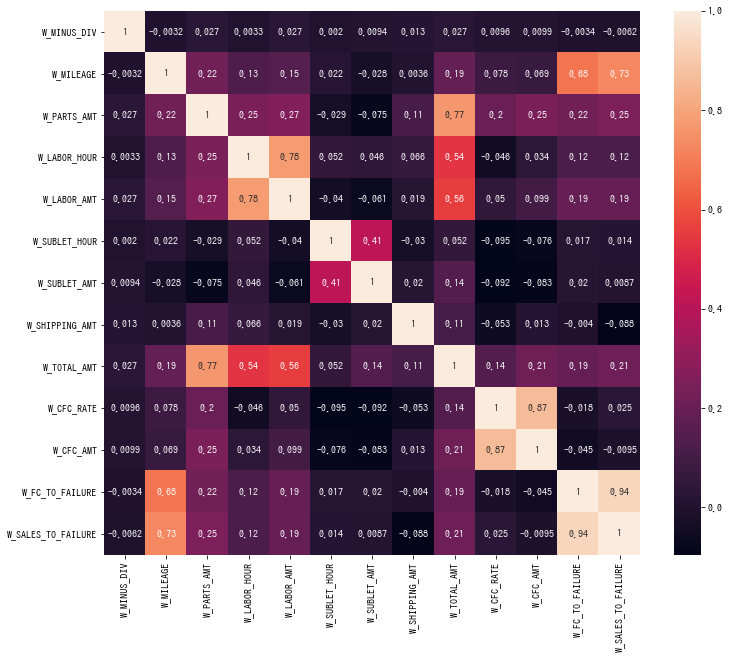

In [21]:
# 相関係数 (df_frocはカテゴリとタイムスタンプのみなので対象外)
for x in ["df_process"]:
    print("%" * 100)
    print(x)
    df_corr = eval(x).corr(method="spearman")
    plt.figure(figsize=(12,10))
    sns.heatmap(df_corr, annot=True)

In [22]:
# 欠損の相関係数
def corr_df(df, figsize= (12,10),savepath=None):
    tmp = df.isna()
    tmp = tmp.loc[:,tmp.nunique() != 1] # drop column having all same number
    df_corr = tmp.corr(method="spearman")
    plt.figure(figsize=figsize)
    sns.heatmap(df_corr, annot=True)
    if savepath: plt.savefig(savepath)
    plt.show()

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
df_froc


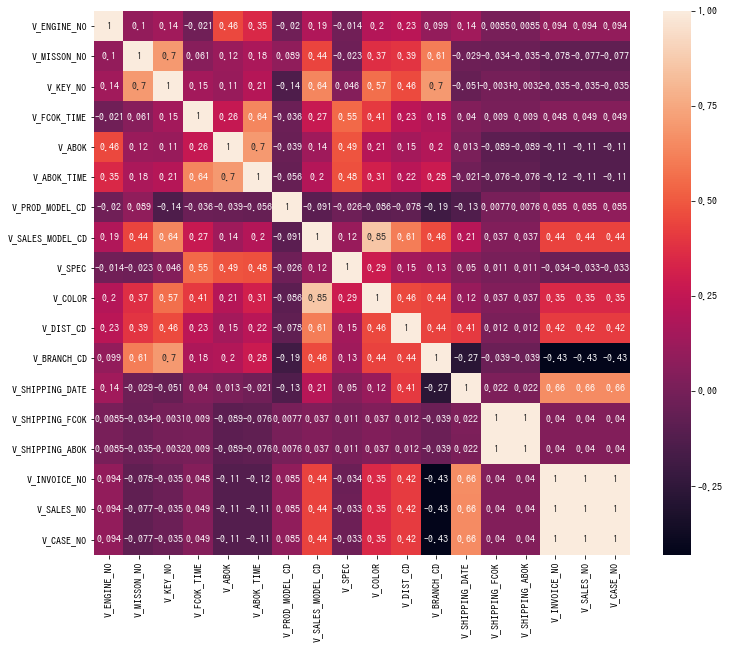

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
df_process


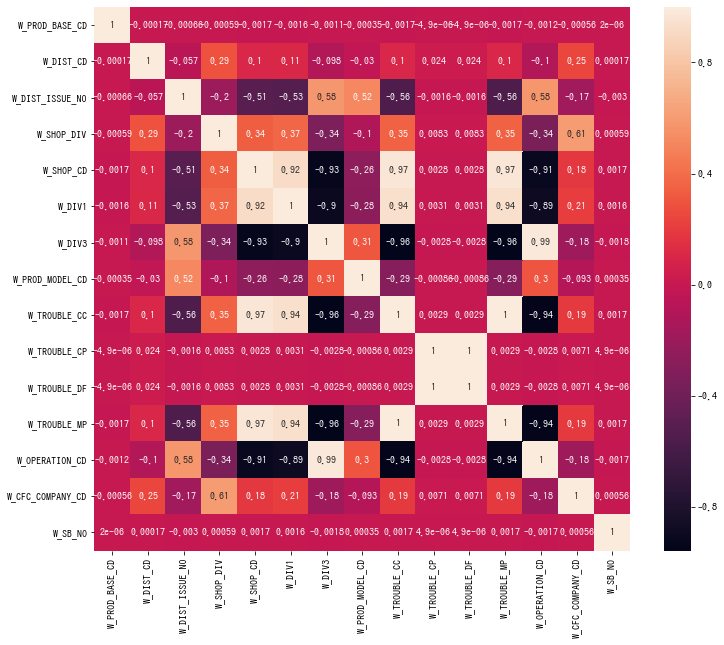

In [23]:
for x in ["df_froc", "df_process"]:
    print("%" * 100)
    print(x)
    corr_df(eval(x), savepath=PATH_REPORTS/f"20190621_{x}_na_corr.png")

In [197]:
df_process["W_FAILURE_DATE"].astype("object").str[:6].value_counts().sort_index().head()

000000    359
000010      4
000018      1
199510      1
199601      1
Name: W_FAILURE_DATE, dtype: int64

In [29]:
dummy = df_process["W_FAILURE_DATE"].astype("object").str[:6]

In [30]:
df_process = df_process[~dummy.isin(["000000","000010", "000018"])]

/Users/localadmin/anaconda3/envs/suzuki/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0.5, 0, 'Failure Month')

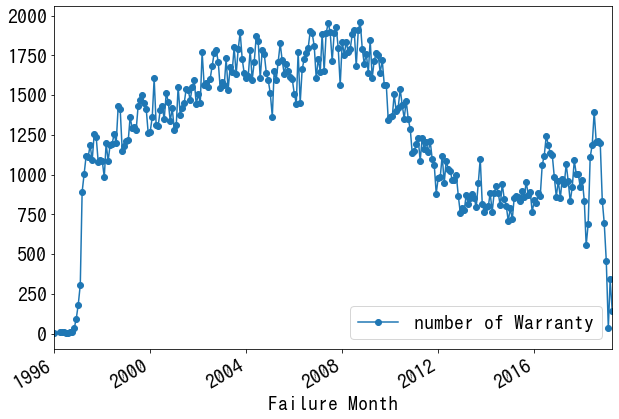

In [31]:
# 時系列プロット(暦日)
df_process["failure_month"] = pd.to_datetime(df_process["W_FAILURE_DATE"].astype("object").str[:6] + "01")
df_process.groupby("failure_month")["W_VIN"].agg({"number of Warranty":len})\
    .plot(marker="o", figsize=(10,7), fontsize=20)
plt.legend(fontsize=20)
plt.xlabel("Failure Month", fontsize=20)

In [206]:
tmp = df_process.groupby("failure_month")["W_VIN"].agg({"number of Warranty":len})

/Users/localadmin/anaconda3/envs/suzuki/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """Entry point for launching an IPython kernel.


In [207]:
top10_move_proc = tmp.diff().abs().\
    sort_values(by="number of Warranty", ascending=False).index[:10]

In [208]:
tmp.diff().loc[top10_move_proc]\
    .rename(columns={"number of Warranty":"change of #Warranty"})\
    .to_csv(PATH_PROCESSED/"change_of_n_proc.csv")

In [25]:
df_process.process_month.agg([max, min])

max   2019-04-01
min   1997-01-01
Name: process_month, dtype: datetime64[ns]

In [26]:
ts_tmp = df_process.groupby("process_month")["W_VIN"].agg(len).to_frame()
month_range = pd.date_range(start='1997/1/1', end='2019/4/1', freq='MS')   
tmp_full = month_range.to_frame(name="month").merge(ts_tmp,
                                         left_on="month",
                                         right_on="process_month",
                                         how="left")

In [27]:
tmp_full[tmp_full.W_VIN.isna()] # 2019年3月のみ、ワランティデータなし。

,month,W_VIN
266,2019-03-01,NaN


In [28]:
np.ceil(1.2)

2.0

In [29]:
def plot_topN(df, group_col, time_col, index_col, topN=10, figsize=(15,10),
             subplot_col=5, fontsize=15):
    df_tmp = df.groupby([group_col, time_col])[index_col].agg({"n":len})
    cat_bestn = df[group_col].value_counts().index[:topN]
    date_min = df[time_col].min()
    date_max = df[time_col].max()

    fig = plt.figure(figsize=figsize)
    for i, g in enumerate(cat_bestn):
        ax = fig.add_subplot(int(np.ceil(topN / subplot_col)),
                             subplot_col, i+1)
        plt.plot(df_tmp.loc[g].index, df_tmp.loc[g].values, "-")
        plt.title(g)
        plt.ylim(0,df_tmp.max()[0] + 1)
        plt.xlim(date_min, date_max)

    fig.add_subplot(111, frameon=False)
    plt.tick_params(labelcolor='none', top='off', bottom='off',
                    left='off', right='off')
    plt.grid(False)
    plt.xlabel(time_col, fontsize=fontsize)
    plt.ylabel("n", fontsize=fontsize)
    plt.tight_layout()
    plt.show()

/Users/localadmin/anaconda3/envs/suzuki/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  This is separate from the ipykernel package so we can avoid doing imports until


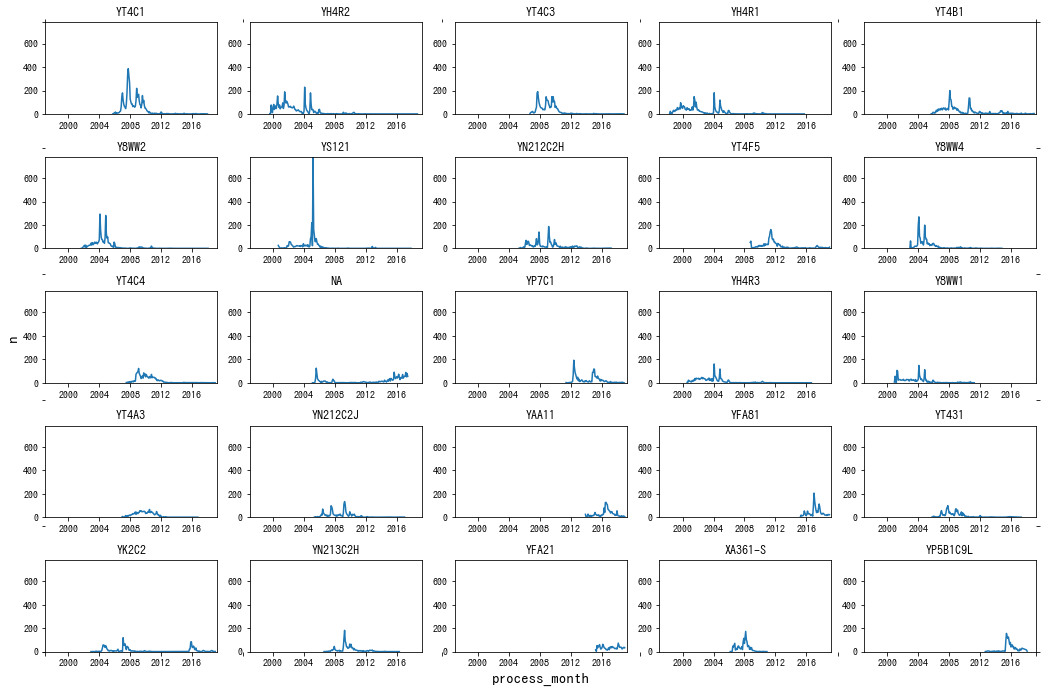

In [30]:
plot_topN(df_process, "W_PROD_MODEL_CD", "process_month", "W_VIN", topN=25)

/Users/localadmin/anaconda3/envs/suzuki/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0.5, 0, 'fcok_month')

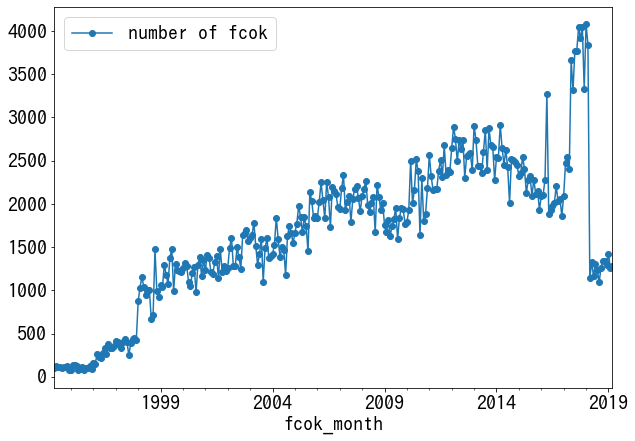

In [10]:
# 時系列プロット(暦日)
df_froc["fcok_month"] = pd.to_datetime(df_froc["V_FCOK"].astype("object").str[:6] + "01")
df_froc.groupby("fcok_month")["V_VIN"].agg({"number of fcok":len})\
    .plot(marker="o", figsize=(10,7), fontsize=20)
plt.legend(fontsize=20)
plt.xlabel("fcok_month", fontsize=20)

In [32]:
datetime.datetime(2015,1,1)

datetime.datetime(2015, 1, 1, 0, 0)

In [35]:
import matplotlib.dates as mdates

In [ ]:
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=4))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
plt.gcf().autofmt_xdate() # Rotation
plt.show()

In [107]:
tmp = df_froc.groupby("fcok_month")["V_VIN"].agg({"number of fcok":len})

/Users/localadmin/anaconda3/envs/suzuki/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """Entry point for launching an IPython kernel.


In [108]:
tmp = tmp.reset_index().resample('MS', on="fcok_month").first()

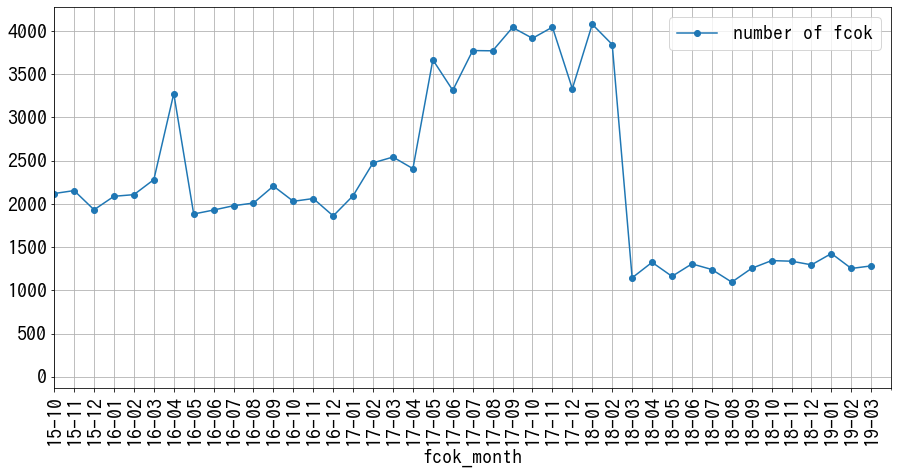

In [109]:
ax = tmp.loc[:,"number of fcok"].plot(figsize=(15,7),
                                               fontsize=20, marker="o")
plt.legend(fontsize=20)
plt.xlabel("fcok_month", fontsize=20)
positions = [p for p in tmp.index]
labels = [l.strftime('%y-%m') for l in positions]

ax.set_xticks(positions)
ax.set_xticklabels(labels)
plt.xticks(rotation=90)
plt.grid()
plt.xlim(datetime.datetime(2015,10,1), datetime.datetime(2019,4,1))

plt.show()

In [78]:
df_froc.head()

,V_BASE_CD,V_PROD_DIV,V_VIN,V_ENGINE_NO,V_MOTOR_NO,V_MISSON_NO,V_KEY_NO,V_FCOK,V_FCOK_TIME,V_ABOK,V_ABOK_TIME,V_PROD_MODEL_CD,V_SALES_MODEL_CD,V_SALES_MODEL_NM,V_SPEC,V_COLOR,V_PLANT_CD,V_DIST_CD,V_BRANCH_CD,V_SHIPPING_DATE,V_SHIPPING_FCOK,V_SHIPPING_ABOK,V_INVOICE_NO,V_SALES_NO,V_CASE_NO,V_SRC_DIV,V_CRT_TIME_STAMP,fcok_month
0,100100,B,JB23W-666295,K6A-A472721,None,1J08828,51141,20111027,253624,20111027,245744,YR6F8BCH,JB23W-JXGU-D8,None,000,Z2S,None,405130,405360,None,None,None,None,None,None,1,16-12-15 17:49:35.835799000,2011-10-01
1,100100,B,HA36S-225349,R06A-K147146,None,53F09951,50757,20150307,132322,20150307,124406,Y3J51BVP,HA36S-ABXQ-A,None,000,ZJ3,None,407100,407750,None,None,None,None,None,None,1,16-12-15 16:50:35.636516000,2015-03-01
2,100100,A,JS1GR7GAX52100978,R736 -140320,None,None,None,20050127,125800,20050127,124700,XA348,GSX750FK5,None,E28,LA1,None,302010,None,20050209,None,None,AS-23748,ADD-1664,321522,1,16-12-15 13:37:27.503402000,2005-01-01
3,100100,B,JSAEGA31S00101811,G16B-138450,None,S513125,U0297,19950222,155400,19950222,114900,YB161CD3,SY416G,None,E18,26U,None,215500,None,19950304,None,None,BT-14907,BWD-3811,000114,1,16-12-15 10:50:49.563035000,1995-02-01
4,118700,A,MH8BE4DUAAJ152177,E470-ID158338,None,None,None,20100915,101900,20100915,100900,XC601-SD,None,None,P12,None,None,None,None,None,None,None,None,None,None,1,16-12-15 17:25:14.435039000,2010-09-01


In [110]:
tmp = df_froc[df_froc.V_SHIPPING_DATE.isna()].groupby("fcok_month")["V_VIN"]\
    .agg({"number of fcok":len})

/Users/localadmin/anaconda3/envs/suzuki/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  


In [111]:
tmp = tmp.reset_index().resample('MS', on="fcok_month").first()

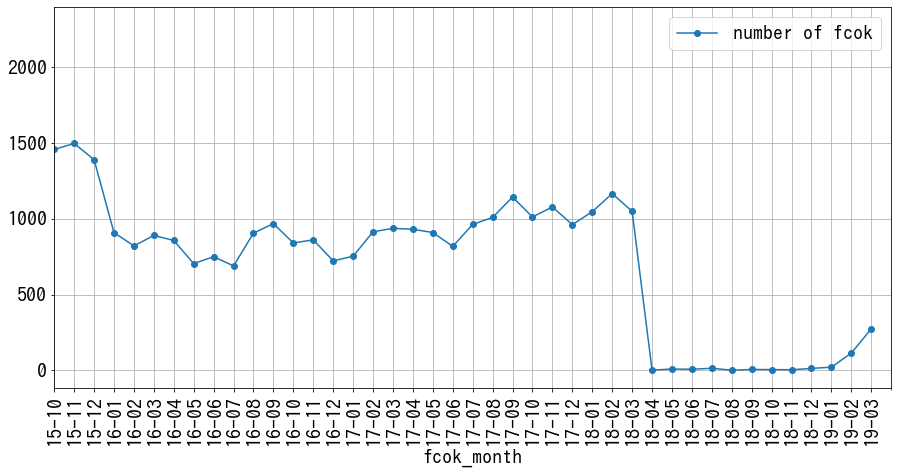

In [112]:
ax = tmp.loc[:,"number of fcok"].plot(figsize=(15,7),
                                               fontsize=20, marker="o")
plt.legend(fontsize=20)
plt.xlabel("fcok_month", fontsize=20)
positions = [p for p in tmp.index]
labels = [l.strftime('%y-%m') for l in positions]

ax.set_xticks(positions)
ax.set_xticklabels(labels)
plt.xticks(rotation=90)
plt.grid()
plt.xlim(datetime.datetime(2015,10,1), datetime.datetime(2019,4,1))

plt.show()

/Users/localadmin/anaconda3/envs/suzuki/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  


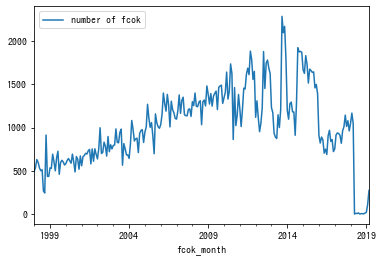

In [89]:
df_froc[df_froc.V_SHIPPING_DATE.isna()].groupby("fcok_month")["V_VIN"]\
    .agg({"number of fcok":len}).plot()

/Users/localadmin/anaconda3/envs/suzuki/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  This is separate from the ipykernel package so we can avoid doing imports until


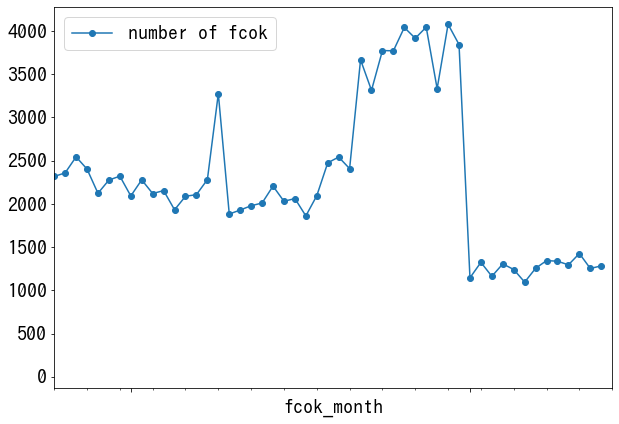

In [56]:
# 時系列プロット(暦日)
df_froc["fcok_month"] = pd.to_datetime(df_froc["V_FCOK"].astype("object").str[:6] + "01")
ax = df_froc.groupby("fcok_month")["V_VIN"].agg({"number of fcok":len})\
    .plot(marker="o", figsize=(10,7), fontsize=20)
ax.xaxis.set_major_locator(mdates.MonthLocator())
plt.legend(fontsize=20)
plt.xlabel("fcok_month", fontsize=20)
plt.xlim(datetime.datetime(2015,1,1), datetime.datetime(2019,4,1))
plt.show()

In [167]:
tmp = df_froc.groupby("fcok_month")["V_VIN"].agg({"number of fcok":len})

/Users/localadmin/anaconda3/envs/suzuki/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """Entry point for launching an IPython kernel.


In [174]:
top10_move_fcok = tmp.diff().abs().sort_values(by="number of fcok", ascending=False).index[:10]

In [179]:
tmp.diff().loc[top10_move_fcok]\
    .rename(columns={"number of fcok":"change of #fcok"})\
    .to_csv(PATH_PROCESSED/"change_of_n_fcok.csv")

In [32]:
df_froc["fcok_month"].agg([max, min])

max   2019-03-01
min   1994-04-01
Name: fcok_month, dtype: datetime64[ns]

In [33]:
ts_tmp = df_froc.groupby("fcok_month")["V_VIN"].agg(len).to_frame()
month_range = pd.date_range(start='1994/4/1', end='2019/3/1', freq='MS')   
tmp_full = month_range.to_frame(name="month").merge(ts_tmp,
                                         left_on="month",
                                         right_on="fcok_month",
                                         how="left")
tmp_full[tmp_full.V_VIN.isna()] # 欠損期間なし

,month,V_VIN


/Users/localadmin/anaconda3/envs/suzuki/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/localadmin/anaconda3/envs/suzuki/lib/python3.6/site-packages/pandas/core/indexing.py:1017: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]


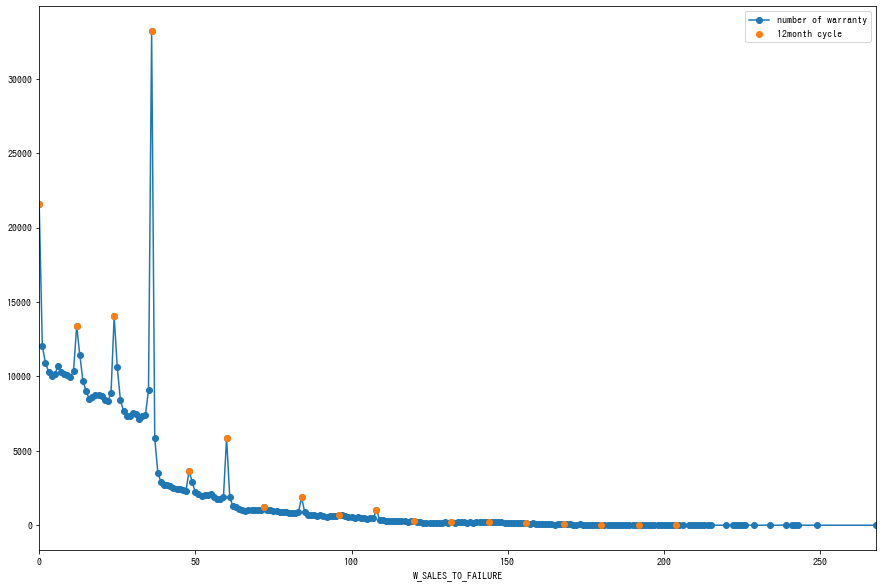

In [34]:
# 時系列プロット(経過期間)
tmp = df_process.groupby("W_SALES_TO_FAILURE")["W_VIN"]\
    .agg({"number of warranty":len})
tmp.plot(marker="o", figsize=(15,10))
x_point = np.arange(0,df_process.W_SALES_TO_FAILURE.max(), 12)
y_point = tmp.loc[x_point, "number of warranty"].values
plt.plot(x_point, y_point, 'o', label="12month cycle")
plt.legend()

/Users/localadmin/anaconda3/envs/suzuki/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  This is separate from the ipykernel package so we can avoid doing imports until


(0, 50)

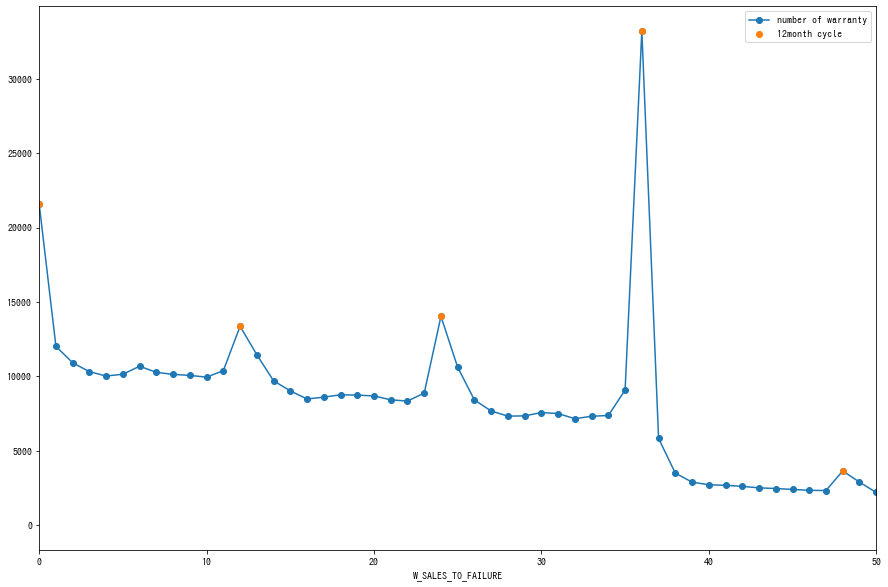

In [35]:
# 時系列プロット(経過期間)
tmp = df_process.groupby("W_SALES_TO_FAILURE")["W_VIN"]\
    .agg({"number of warranty":len})
tmp.plot(marker="o", figsize=(15,10))
x_point = np.arange(0,df_process.W_SALES_TO_FAILURE.max(), 12)
y_point = tmp.loc[x_point, "number of warranty"].values
plt.plot(x_point, y_point, 'o', label="12month cycle")
plt.legend()
plt.xlim(0,50)

/Users/localadmin/anaconda3/envs/suzuki/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  This is separate from the ipykernel package so we can avoid doing imports until


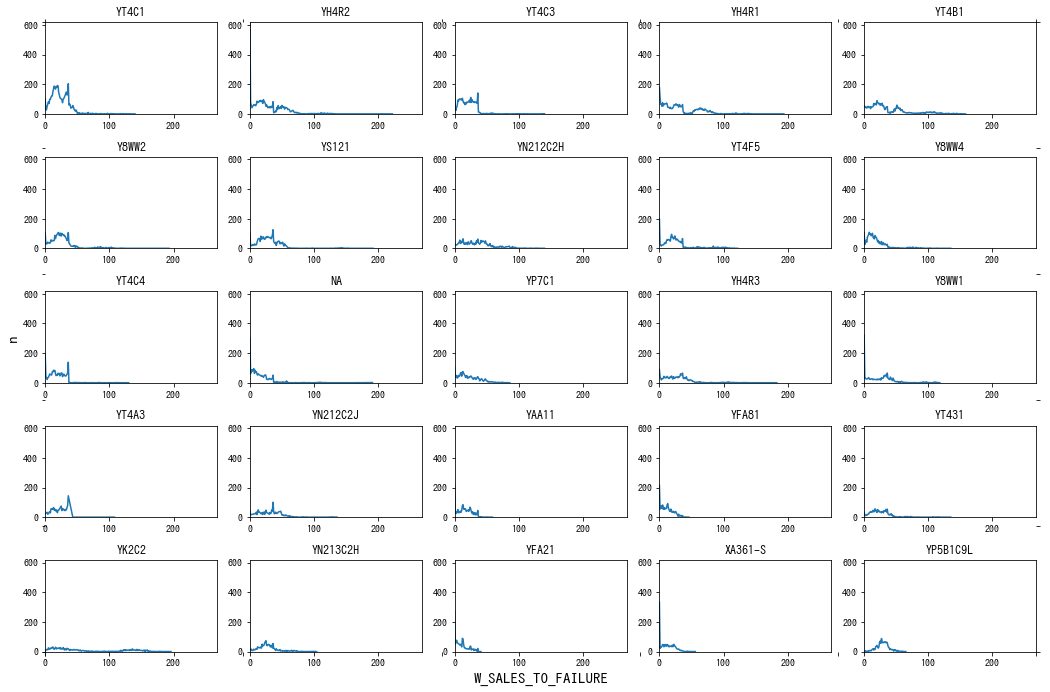

In [36]:
plot_topN(df_process, "W_PROD_MODEL_CD", "W_SALES_TO_FAILURE", "W_VIN",
         topN=25)

## カテゴリ

- PROD_MODEL_CDについて、4輪は上3桁、2輪は上4桁でまとめてカテゴリ種類数を確認した
- CAUSAL_PART_NOについて、上5桁-3桁でまとめてカテゴリ種類数を確認した

### W_PROD_MODEL_CD

In [37]:
df_process["W_PROD_MODEL_CD"].fillna("!!!", inplace=True)
proc_prod_model_cd = df_process.groupby("W_PROD_MODEL_CD")["W_KEY"].agg(len)

In [63]:
df_process_4w = df_process[np.logical_and(df_process.W_PROD_DIV == "B",
                                         df_process.W_FIELD_CLAIM_DIV != "3")]
df_process_2w = df_process[np.logical_and(df_process.W_PROD_DIV == "A",
                                           df_process.W_FIELD_CLAIM_DIV != "3")]

In [65]:
print(df_process_4w.shape)
print(df_process_2w.shape)

(418757, 49)
(75468, 49)


In [66]:
proc_prod_model_cd_4w_raw = df_process_4w.groupby("W_PROD_MODEL_CD")["W_KEY"].agg(len)
proc_prod_model_cd_2w_raw = df_process_2w.groupby("W_PROD_MODEL_CD")["W_KEY"].agg(len)

In [67]:
for name, x in [("4w", proc_prod_model_cd_4w_raw),
          ("2w", proc_prod_model_cd_2w_raw)]:
    print(name, ":", x.shape)

4w : (7888,)
2w : (2495,)


In [68]:
df_process_4w["W_PROD_MODEL_CD_short"] = df_process_4w["W_PROD_MODEL_CD"].str[:3]
df_process_2w["W_PROD_MODEL_CD_short"] = df_process_2w["W_PROD_MODEL_CD"].str[:4]

/Users/localadmin/anaconda3/envs/suzuki/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [69]:
proc_prod_model_cd_4w = df_process_4w.groupby("W_PROD_MODEL_CD_short")["W_KEY"].agg(len)
proc_prod_model_cd_2w = df_process_2w.groupby("W_PROD_MODEL_CD_short")["W_KEY"].agg(len)

In [70]:
for name, x in [("4w", proc_prod_model_cd_4w),
          ("2w", proc_prod_model_cd_2w)]:
    print(name, ":", x.shape)

4w : (186,)
2w : (384,)


In [71]:
tmp = pd.concat([proc_prod_model_cd_2w, proc_prod_model_cd_4w], axis=0)

Text(52, 0.7000000000000001, 'x=52')

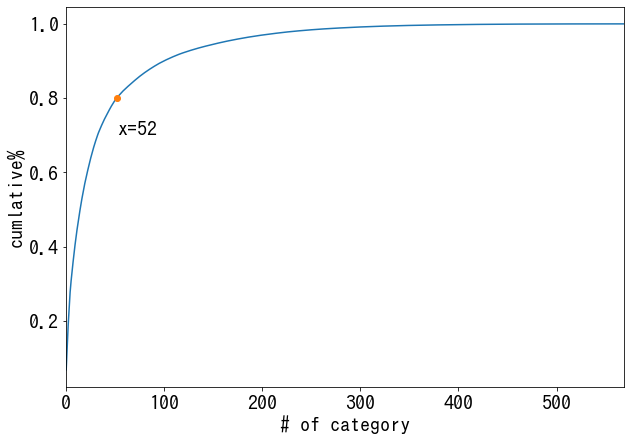

In [72]:
tmp = tmp.sort_values(ascending=False).reset_index()\
    .rename(columns={"W_KEY":"n"})
tmp["cumlative%"] = tmp.n.cumsum() / tmp.n.sum()

tmp["cumlative%"].plot(fontsize=20, figsize=(10,7))
plt.ylabel('cumlative%', fontsize=20)
plt.xlabel("# of category", fontsize=20)

x_point = tmp.index[tmp["cumlative%"] > 0.8][0]
y_point = tmp.loc[x_point,"cumlative%"]
plt.plot([x_point], [y_point], 'o')
plt.annotate(f'x={x_point}', xy=(x_point, 0.8),
             xytext=(x_point, 0.8 - 0.1),
             fontsize=20)

In [73]:
df_process["W_CAUSAL_PART_NO_short"] = df_process["W_CAUSAL_PART_NO"].str[:9]

Text(463, 0.4, 'x=463')

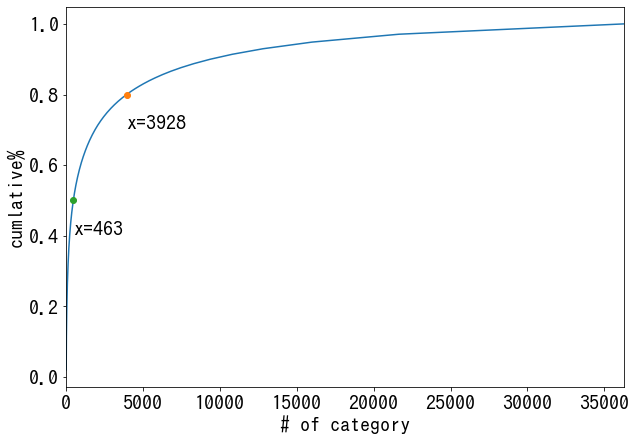

In [82]:
tmp = df_process.W_CAUSAL_PART_NO_short.value_counts().reset_index()\
    .rename(columns={"W_CAUSAL_PART_NO_short":"n"})
tmp["cumlative%"] = tmp.n.cumsum() / tmp.n.sum()

tmp["cumlative%"].plot(fontsize=20, figsize=(10,7))
plt.ylabel('cumlative%', fontsize=20)
plt.xlabel("# of category", fontsize=20)

x_point = tmp.index[tmp["cumlative%"] > 0.8][0]
y_point = tmp.loc[x_point,"cumlative%"]
plt.plot([x_point], [y_point], 'o')
plt.annotate(f'x={x_point}', xy=(x_point, 0.8),
             xytext=(x_point, 0.8 - 0.1),
             fontsize=20)
x_point = tmp.index[tmp["cumlative%"] > 0.5][0]
y_point = tmp.loc[x_point,"cumlative%"]
plt.plot([x_point], [y_point], 'o')
plt.annotate(f'x={x_point}', xy=(x_point, 0.5),
             xytext=(x_point, 0.5 - 0.1),
             fontsize=20)

In [78]:
df_process.W_FIELD_CLAIM_DIV.unique()

array(['2', '1', '0'], dtype=object)

In [77]:
df_process[df_process.W_FIELD_CLAIM_DIV != "3"].shape

(500000, 50)

## 使用する項目の選定

**生産データ(7項目)**
- V_VIN: VIN
- V_FCOK: 車両完成検査日
- V_PROD_MODEL_CD: 生産機種番号(四輪は上3桁、二輪は上2桁を使用)
- V_SPEC: 仕向地
- V_PROD_DIV: 製品区分
- V_BASE_CD: 生産拠点
- V_DIST_CD: 出荷先代理店(欠損が30%あるため、使用は難しい可能性。定性的観点から、まだ使用の可能性を排除しない)

**ワランティデータ(19項目)**
- W_VIN: VIN
- W_KEY: ワランティ番号
- W_FIELD_CLAIM_DIV: 市場クレーム区分
- W_PROCESSED_MONTH: 処理月
- W_FAILURE_DATE: 故障日
- W_SALES_TO_FAILURE: 販売から故障までの月数
- W_MILEAGE: 走行距離
- W_MILEAGE_DIV: 走行距離区分
- W_TROUBLE_DF: 故障コード 状況
- W_TROUBLE_CP: 故障コード 現象
- W_PROD_MODEL_CD: 生産機種番号(四輪は上3桁、二輪は上2桁を使用)
- W_CAUSAL_PART_NO: 主原因品番(上5桁-3桁を使用)
- W_DIST_CD: 出荷先代理店
- W_DIST_COUNTRY_CD: 出荷先国
- W_DMEX_DIV: 輸出入区分
- W_PROD_DIV: 製品区分
- W_BASE_CD: 処理拠点
- W_PROD_BASE_CD: 生産拠点
- W_FCOK: 車両完成検査日
- W_DIV2: クレームタイプ(パワートレイン, 錆, エミッションなど)

In [7]:
df_fcok_sub = df_froc.loc[:, ["V_VIN", "V_FCOK", "V_PROD_MODEL_CD",
                              "V_SPEC", "V_PROD_DIV", "V_BASE_CD",
                              "V_DIST_CD"]]

In [8]:
df_proc_sub = df_process.loc[:, ["W_VIN", "W_KEY", "W_FIELD_CLAIM_DIV",
                            "W_PROCESS_MONTH", "W_FAILURE_DATE",
                            "W_SALES_TO_FAILURE", "W_MILEAGE",
                            "W_MILEAGE_DIV", "W_TROUBLE_DF",
                            "W_TROUBLE_CP", "W_PROD_MODEL_CD",
                            "W_CAUSAL_PART_NO", "W_DIST_CD",
                            "W_DIST_COUNTRY_CD", "W_DMEX_DIV",
                            "W_PROD_DIV", "W_BASE_CD",
                            "W_PROD_BASE_CD", "W_FCOK", "W_DIV2"]]

In [9]:
df_proc_sub.to_feather(PATH_INTERIM_DATA/"20190624_dbhaa_random_500_000_sub.feather")
df_fcok_sub.to_feather(PATH_INTERIM_DATA/"20190624_tbhaa_random_500_000_sub.feather")

## 外れ値の処理/除外

In [125]:
df_proc_sub.W_MILEAGE_DIV.value_counts()

K    494375
H      5625
Name: W_MILEAGE_DIV, dtype: int64

In [131]:
df_proc_sub["mileage"] = df_proc_sub[["W_MILEAGE_DIV", "W_MILEAGE"]].apply(
    lambda x: x[1] if x[0] == "K" else None, axis=1)

In [133]:
df_proc_sub["hour"] = df_proc_sub[["W_MILEAGE_DIV", "W_MILEAGE"]].apply(
    lambda x: x[1] if x[0] == "H" else None, axis=1)

In [137]:
df_proc_sub.drop(["W_MILEAGE_DIV", "W_MILEAGE"], axis=1, inplace=True)

In [128]:
df_proc_sub["W_CAUSAL_PART_NO"] = df_proc_sub["W_CAUSAL_PART_NO"].str[:9]

In [119]:
def modify_model_code(x):
    if x[0] == "A":
        res = x[1][:4]
    elif x[0] == "B":
        res = x[1][:3]
    else:
        res = x[1]
    return res

In [136]:
df_proc_sub["W_PROD_MODEL_CD"] = df_proc_sub[["W_PROD_DIV", "W_PROD_MODEL_CD"]]\
    .apply(modify_model_code, axis=1)

In [138]:
# 基礎統計量一覧
for x in ["df_proc_sub", "df_fcok_sub"]: 
    print(x)
    tmp = eval(x).describe(include="all")
    display(tmp)
    tmp.to_csv(PATH_PROCESSED/f"20190621_describe_{x}.csv")

df_proc_sub


,W_VIN,W_KEY,W_FIELD_CLAIM_DIV,W_PROCESS_MONTH,W_FAILURE_DATE,W_SALES_TO_FAILURE,W_TROUBLE_DF,W_TROUBLE_CP,W_PROD_MODEL_CD,W_CAUSAL_PART_NO,W_DIST_CD,W_DIST_COUNTRY_CD,W_DMEX_DIV,W_PROD_DIV,W_BASE_CD,W_PROD_BASE_CD,W_FCOK,W_DIV2,mileage,hour
count,500000,500000,500000,500000,500000,500000.000000,499994,499994,500000,500000,492614,500000,500000,500000,500000,499999,500000,500000,494375.000000,5625.000000
unique,487259,500000,3,267,8228,NaN,537,297,1514,36293,998,112,2,7,9,29,6003,11,NaN,NaN
top,JS3TD62V6X4102081,WRUSJP201703B001638,1,200903,00000000,NaN,99,99,YT4,76191-62J,1013B,JP,1,B,100100,100100,20060301,0,NaN,NaN
freq,5,1,348980,3626,359,NaN,64022,142269,33739,10329,32028,195951,284125,418757,425709,380042,3515,350957,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,29.296378,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25626.471462,262.601956
std,NaN,NaN,NaN,NaN,NaN,27.509922,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23799.828010,857.217076
min,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
25%,NaN,NaN,NaN,NaN,NaN,10.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6547.500000,0.000000
50%,NaN,NaN,NaN,NaN,NaN,24.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19200.000000,16.000000
75%,NaN,NaN,NaN,NaN,NaN,36.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38341.500000,155.000000


df_fcok_sub


,V_VIN,V_FCOK,V_PROD_MODEL_CD,V_SPEC,V_PROD_DIV,V_BASE_CD,V_DIST_CD
count,500000,500000,491373,480652,500000,500000,351226
unique,500000,8038,15580,204,5,25,2829
top,DA64V-783318,20180112,XF331EH,000,B,100100,304010
freq,1,216,5330,160226,314460,313579,18428


%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
df_proc_sub


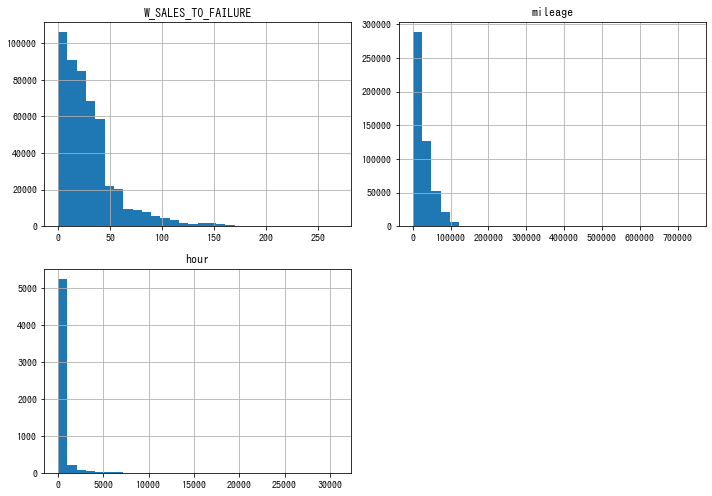

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
df_fcok_sub


<Figure size 720x504 with 0 Axes>

In [139]:
bins=30
for x in ["df_proc_sub", "df_fcok_sub"]:
    print("%" * 100)
    print(x)
    hist_df(eval(x), bin=bins,
            savepath=PATH_REPORTS/f"20190621_{x}_hist_bins{bins}.png",
           figsize=(10,7), subplot_col=2)

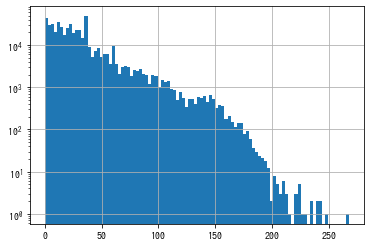

In [106]:
df_proc_sub.W_SALES_TO_FAILURE.hist(bins=100)
plt.yscale('log')

In [110]:
df_proc_sub.W_SALES_TO_FAILURE.value_counts().sort_index(ascending=False).head(30)

268    1
249    1
243    1
242    1
241    1
239    1
234    2
229    1
226    1
225    1
224    3
223    1
222    2
220    1
215    1
214    1
213    1
212    1
211    2
210    4
209    1
208    2
206    2
205    2
204    1
203    2
202    3
201    3
200    1
199    1
Name: W_SALES_TO_FAILURE, dtype: int64

外れ値ではないと判断

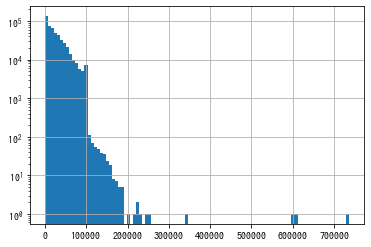

In [140]:
df_proc_sub.mileage.hist(bins=100)
plt.yscale('log')

In [141]:
df_proc_sub.mileage.value_counts().sort_index(ascending=False).head(30)

736892.0    1
608236.0    1
602351.0    1
345250.0    1
254242.0    1
245572.0    1
229750.0    1
226102.0    1
221541.0    1
215657.0    1
201254.0    1
189560.0    1
189345.0    1
188789.0    1
187900.0    1
187485.0    1
181119.0    1
179702.0    1
177248.0    1
177233.0    1
176935.0    1
175188.0    1
173923.0    1
173161.0    1
171681.0    1
171612.0    1
171422.0    1
171351.0    1
168202.0    1
167289.0    1
Name: mileage, dtype: int64

件数が少ないので無視しても影響はないが、影響がありそうな場合は、300000Km以上を除去。
恐らく入力エラーではないと思われる。

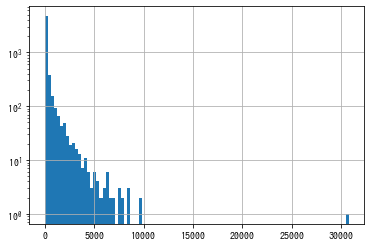

In [142]:
df_proc_sub.hour.hist(bins=100)
plt.yscale('log')

In [144]:
df_proc_sub.hour.value_counts().sort_index(ascending=False).head(5)

30800.0    1
9771.0     1
9600.0     1
8553.0     1
8456.0     1
Name: hour, dtype: int64

件数が少ないので無視しても影響はないが、影響がありそうな場合は、10000時間以上を除去。 恐らく入力エラーではないと思われる。

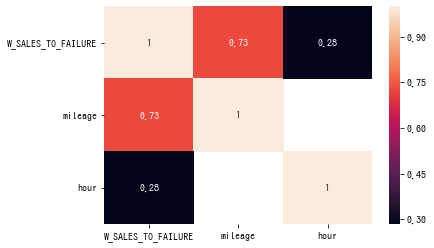

In [150]:
df_corr = df_proc_sub.corr(method="spearman")
sns.heatmap(df_corr, annot=True)

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
df_proc_sub


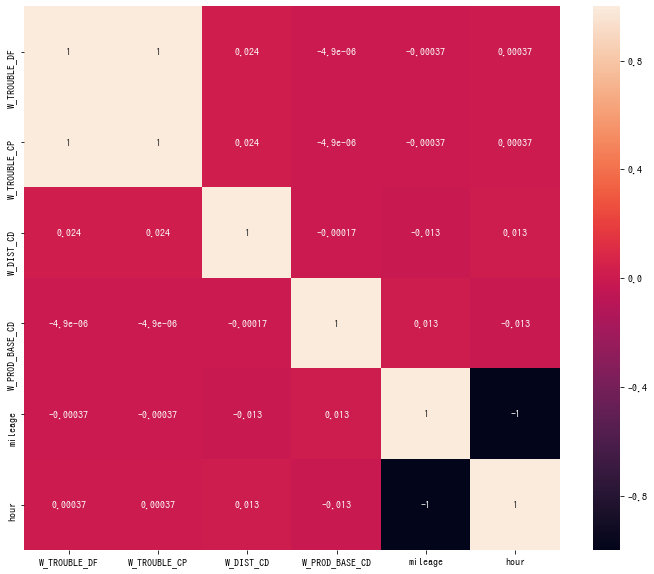

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
df_fcok_sub


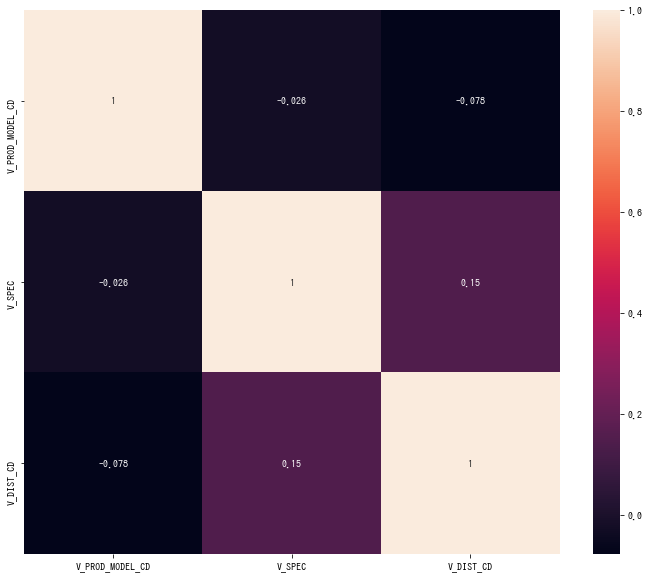

In [151]:
for x in ["df_proc_sub", "df_fcok_sub"]:
    print("%" * 100)
    print(x)
    corr_df(eval(x), savepath=PATH_REPORTS/f"20190621_{x}_na_corr.png")

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
df_proc_sub


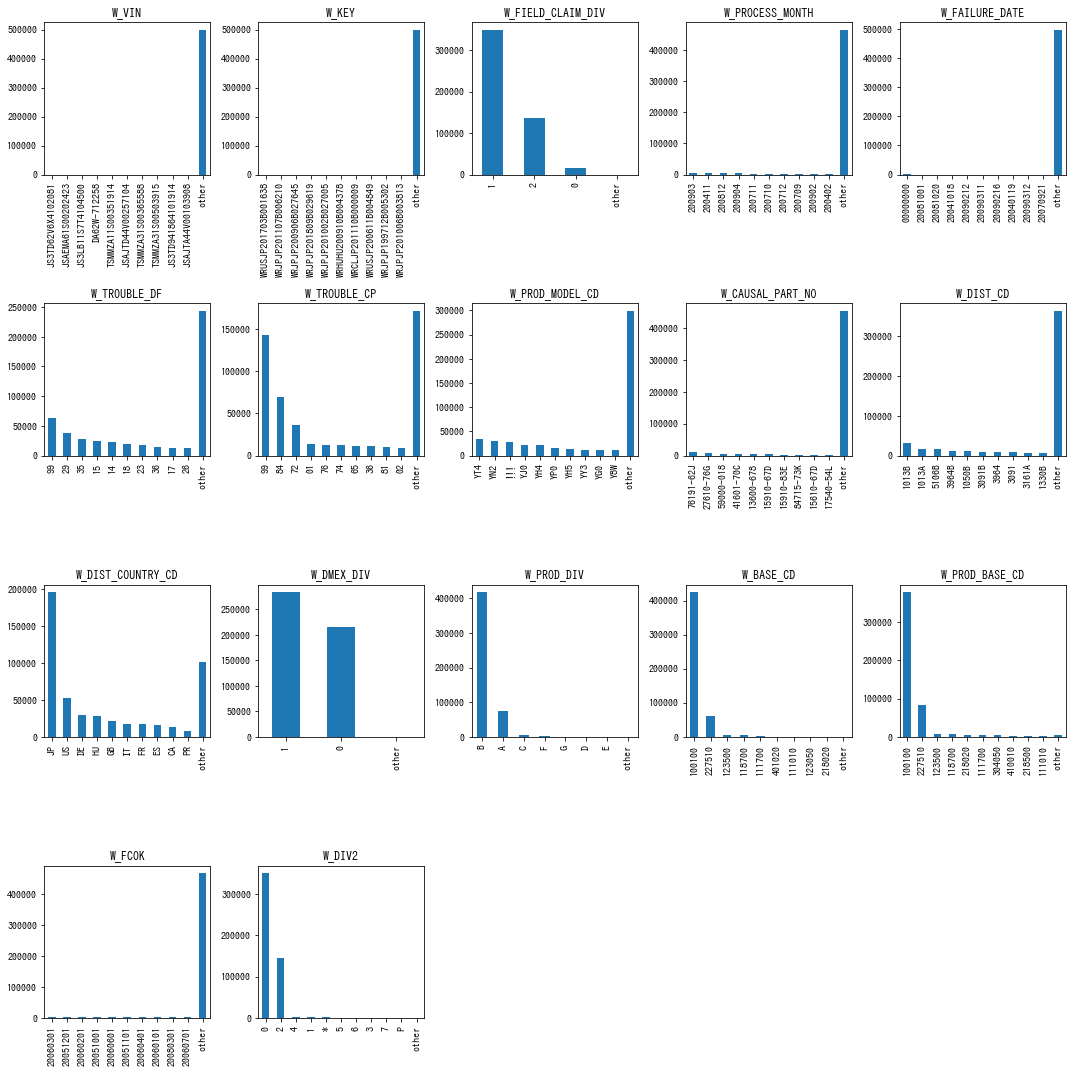

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
df_fcok_sub


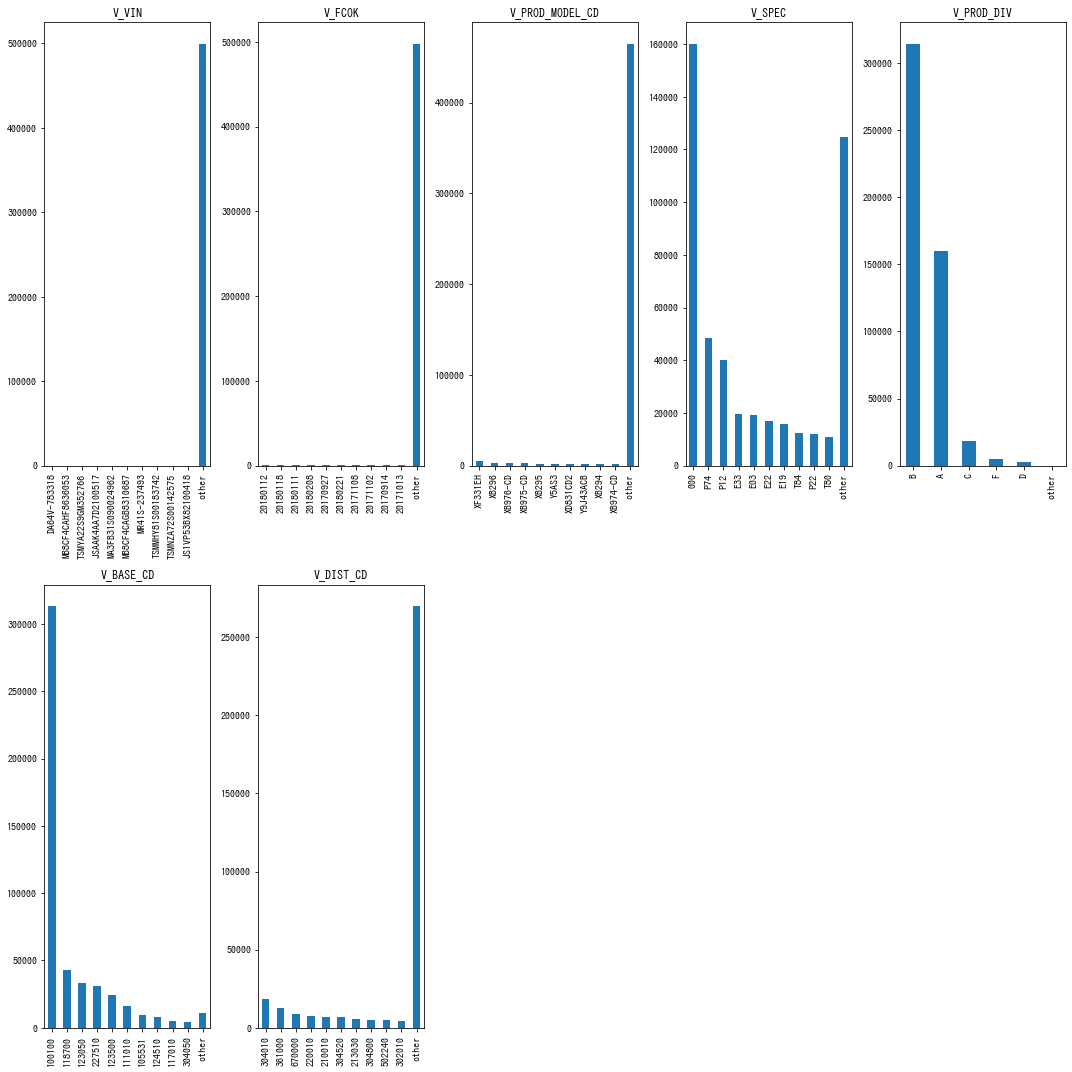

In [155]:
for x in ["df_proc_sub", "df_fcok_sub"]:
    print("%" * 100)
    print(x)
    cat_df(eval(x), n_topcat=10,
            savepath=PATH_REPORTS/f"20190621_{x}_cat_bar_top10.png",
          figsize=(15,15))

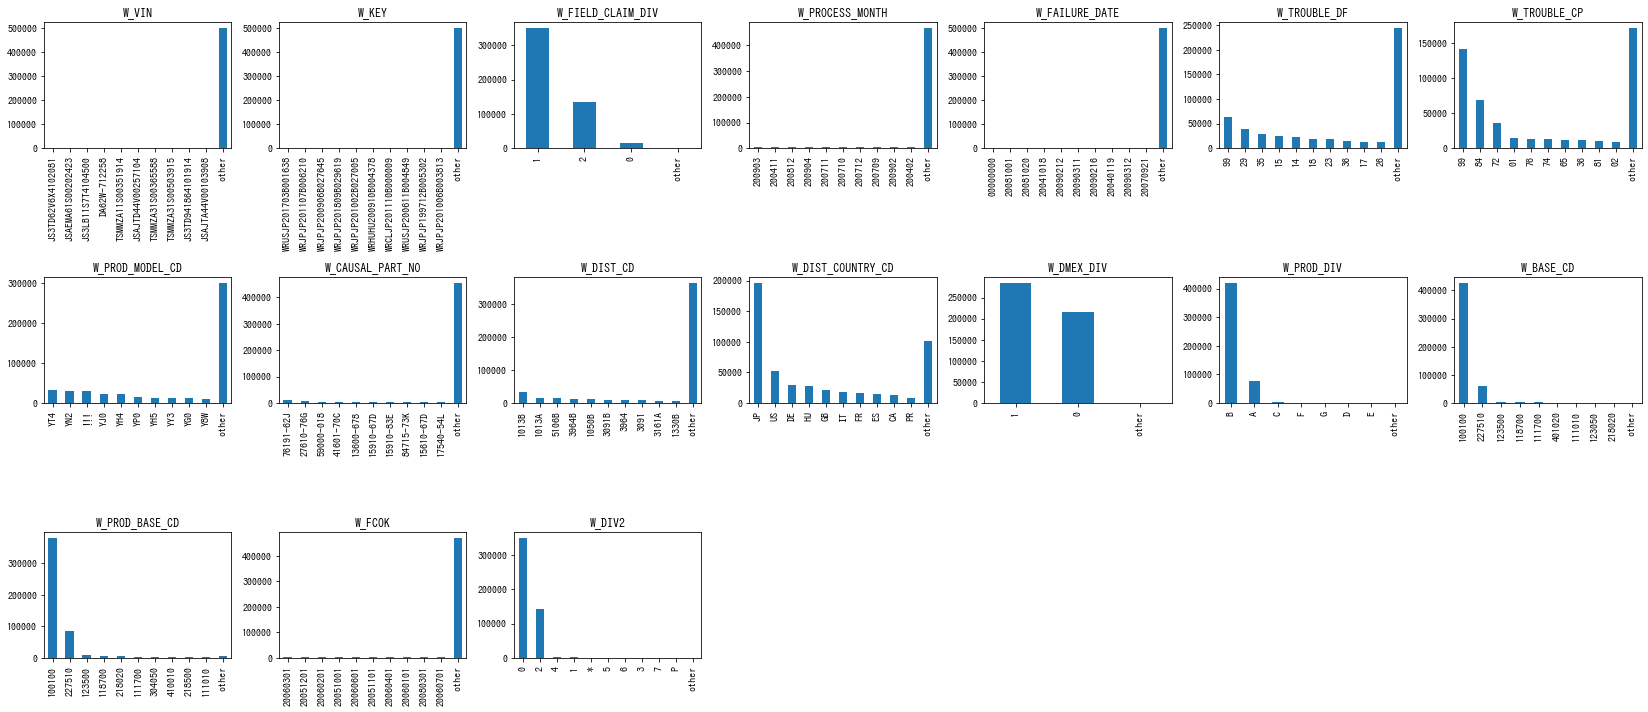

In [161]:
cat_df(df_proc_sub, n_topcat=10,
            savepath=PATH_REPORTS/f"20190621_df_proc_sub_cat_bar_top10.png",
          figsize=(23,10), subplot_col=7)